# Import & Load data

In [1]:
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from matplotlib.offsetbox import AnchoredText
from matplotlib.patches import Rectangle
import math
from IPython.display import display, Markdown, HTML
from scipy import stats
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.lines import Line2D

In [2]:
driving_data_file_path = "../data-cleanup/merged-cleaned-csv/driving_data_merged_1_to_49.csv"
driving_data_original = pd.read_csv(driving_data_file_path)

# Exclude participants

In [3]:
# If we want to exclude participants, do it here by their ID
guess_excluded = [5,27,29]
diff_excluded = [10,14,16]
control_excluded = [34,42,45]

exclusion_list = guess_excluded + diff_excluded + control_excluded
#exclusion_list = []

# Remove all rows which are of participants who are in the exclusion_list
# .copy() is important to avoid warnings later, if .copy() not used and we modify driving_data, driving_data_original will be affected too!
driving_data = driving_data_original[~driving_data_original.user_id.isin(exclusion_list)].copy()

# Convert throttle position from [0,1] to [0,100]
driving_data["throttle_position"] *= 100
driving_data["range_estimate"] = round(driving_data["range_estimate"],0)

# Number of participants in each group

In [4]:
# Total number of participants
total_number_of_participants = len(driving_data.user_id.unique())

# Get a df with all unique ids and count the number of users in each group
unique_ids = driving_data.groupby(["evis_id", "user_id"], as_index=False).count() 
number_of_participants_diff = len(unique_ids[unique_ids["evis_id"] == "diff_and_cope1"])
number_of_participants_guess = len(unique_ids[unique_ids["evis_id"] == "guess_o_meter"])
number_of_participants_control = len(unique_ids[unique_ids["evis_id"] == "control_group"])

number_of_participants = pd.DataFrame(data={
    "diff_and_cope1":[number_of_participants_diff], 
    "guess_o_meter":[number_of_participants_guess], 
    "control_group":[number_of_participants_control],
    "total": [sum([number_of_participants_control, number_of_participants_diff, number_of_participants_guess])]}, 
    index=["N"])

number_of_participants

,diff_and_cope1,guess_o_meter,control_group,total
N,13,14,13,40


# Success ratio  
A successful attempt 7998m driven, accounts for one half car lenght of 2m

In [5]:
# Group based on attempt, evis and user id.
each_user = driving_data.groupby(["attempt", "evis_id","user_id"], as_index=False)

# Create a new df with the last datapoint for each attempt
each_user_final_data = each_user.tail(1)

# See it as successful if they are less than a car lenght from the target
successful_distance = 7998

failed_attempts = each_user_final_data[each_user_final_data.distance_traveled < successful_distance]
successful_attempts = each_user_final_data[each_user_final_data.distance_traveled >= successful_distance]

successrate_df = successful_attempts.groupby(["attempt", "evis_id"]).count()[["user_id", "timestamp"]]
successrate_df["timestamp"] = failed_attempts.groupby(["attempt", "evis_id"]).count()
successrate_df = successrate_df.rename(columns={
  "user_id": "successful",
  "timestamp": "failed"
})

successrate_df["failed"] = successrate_df["failed"].apply(lambda x: 0 if math.isnan(x) else int(x))

successrate_df["success rate %"] = successrate_df.apply(lambda x: x["successful"]/(x["successful"]+x["failed"])*100, axis=1)
successrate_df["success rate %"] = successrate_df["success rate %"].round(1)
successrate_df["N"] = successrate_df.apply(lambda x: x["successful"] + x["failed"], axis=1)
successrate_df["N"] = successrate_df["N"].apply(lambda x: int(x))

successrate_df

successful  failed  success rate %   N
attempt evis_id                                               
1       control_group            6       7            46.2  13
        diff_and_cope1           7       6            53.8  13
        guess_o_meter            3      11            21.4  14
2       control_group           11       2            84.6  13
        diff_and_cope1          12       1            92.3  13
        guess_o_meter            9       5            64.3  14

## Here we can adjust which variable to normalize against  
Choose which variable to normalize against. Which means we split that specific variable in to steps with equal distance. Each datapoint is then averaged around these points

In [7]:
variable_to_normalize_against = "current_soc"  
#variable_to_normalize_against = "range_estimate"  
#variable_to_normalize_against = "distance_traveled" 

# Decide which distance interval to average over
if variable_to_normalize_against == "current_soc":
  normalizing_window_size = 0.01 # kWh

if variable_to_normalize_against == "distance_traveled":
  normalizing_window_size = 50 # m
  
# Calculate which distance window the row should belong to
def assignDistanceWindow(value):
    normalizing_window_index = round(value / normalizing_window_size)
    return normalizing_window_size * normalizing_window_index

# Add a new column which stores the distance window the distance traveled fits in
driving_data["normalizing_window"] = driving_data[variable_to_normalize_against].apply(assignDistanceWindow)

# The range estimate seen by the driver using the guess-o-meter & control group is truncated
driving_data["seen_range_estimate"] = driving_data["range_estimate"].apply(lambda x: int(x))

# Mean and standard deviation + separation of successful and failed attempts

In [8]:
# Get the average and std of each distance window for each user in each drivign attempt
average_individual = driving_data.groupby(["attempt", "evis_id", "user_id", "normalizing_window"], as_index=False).mean()
std_individual = driving_data.groupby(["attempt", "evis_id", "user_id", "normalizing_window"], as_index=False).std()

# Get the mean and std for each attempt in each group
average_groups = average_individual.groupby(["attempt", "evis_id", "normalizing_window"], as_index=False).mean()
std_groups = average_individual.groupby(["attempt", "evis_id", "normalizing_window"], as_index=False).std()

In [9]:
## Successful and failed attempts separated ##
only_failed_attempts = []
for index, row in failed_attempts.iterrows():
  id = row.user_id
  attempt = row.attempt
  failed_attempt = driving_data[((driving_data.user_id == id) & (driving_data.attempt == attempt))]
  only_failed_attempts.append(failed_attempt)
  
only_failed_attempts = pd.concat(only_failed_attempts)

# Get the average and std of each distance window for each user in each drivign attempt
average_individual_failed = only_failed_attempts.groupby(["attempt", "evis_id", "user_id", "normalizing_window"], as_index=False).mean()
std_individual_failed = only_failed_attempts.groupby(["attempt", "evis_id", "user_id", "normalizing_window"], as_index=False).std()

# Get the mean and std for each attempt in each group
average_groups_failed = average_individual_failed.groupby(["attempt", "evis_id", "normalizing_window"], as_index=False).mean()
std_groups_failed = average_individual_failed.groupby(["attempt", "evis_id", "normalizing_window"], as_index=False).std()

# Get average for all failed attempts
average_all_evis_failed = average_individual_failed.groupby(["attempt", "normalizing_window"], as_index=False).mean()
std_all_evis_failed = average_individual_failed.groupby(["attempt", "normalizing_window"], as_index=False).std()

In [10]:
only_successful_attempts = []
for index, row in successful_attempts.iterrows():
    id = row.user_id
    attempt = row.attempt
    successful_attempt = driving_data[((driving_data.user_id == id) & (driving_data.attempt == attempt))]
    only_successful_attempts.append(successful_attempt)
    
only_successful_attempts = pd.concat(only_successful_attempts)

# Get the average and std of each distance window for each user in each drivign attempt
average_individual_successful = only_successful_attempts.groupby(["attempt", "evis_id", "user_id", "normalizing_window"], as_index=False).mean()
std_individual_successful = only_successful_attempts.groupby(["attempt", "evis_id", "user_id", "normalizing_window"], as_index=False).std()

# Get the mean and std for each attempt in each group
average_groups_successful = average_individual_successful.groupby(["attempt", "evis_id", "normalizing_window"], as_index=False).mean()
std_groups_successful = average_individual_successful.groupby(["attempt", "evis_id", "normalizing_window"], as_index=False).std()

# Get average for all successful attempts
average_all_evis_successful = average_individual_successful.groupby(["attempt", "normalizing_window"], as_index=False).mean()
std_all_evis_successful = average_individual_successful.groupby(["attempt", "normalizing_window"], as_index=False).std()

### Road elevation

In [11]:
# Get the average road height for each distance window
road_elevation = average_groups[["normalizing_window", "road_elevation"]]
road_elevation = road_elevation.groupby(["normalizing_window"], as_index=False).mean()

## Medelvärden

In [12]:
failed_attempts_groups_mean = only_failed_attempts.groupby(["attempt","evis_id"]).mean()[["speed","distance_traveled","power_usage","throttle_position","timestamp"]]
failed_attempts_groups_median = only_failed_attempts.groupby(["attempt","evis_id"]).median()[["speed","distance_traveled","power_usage","throttle_position","timestamp"]]
failed_attempts_groups_sd = only_failed_attempts.groupby(["attempt","evis_id"]).std()[["speed","distance_traveled","power_usage","throttle_position","timestamp"]]



#only_failed_attempts[(only_failed_attempts.attempt == 1) & (only_failed_attempts)]

df1 = failed_attempts_groups_mean[["distance_traveled"]]
df1 = df1.rename(columns={"distance_traveled":"mean"})
df1["median"] = failed_attempts_groups_median[["distance_traveled"]]
df1["SD"] = failed_attempts_groups_sd[["distance_traveled"]]

df1.astype(int)


mean  median    SD
attempt evis_id                           
1       control_group   2673    2332  1948
        diff_and_cope1  2934    2589  2058
        guess_o_meter   2239    2048  1556
2       control_group   2058    1855  1478
        diff_and_cope1  2403    2358  1451
        guess_o_meter   3381    3055  2212

## Group averages (POWER)

In [13]:
variables_print_pretty = {
  "diff_and_cope1": "Diff & COPE1",
  "guess_o_meter": "Guess-o-meter",
  "control_group": "Control group",
  "speed": "Speed",
  "power_usage": "Power",
  "throttle_position": "Throttle",
  "current_soc": "State of charge"
}
variables_unit = {
  "speed": "[km/h]",
  "power_usage": "[kW]",
  "throttle_position": "[%]",
  "current_soc": "[kWh]"
}
matplot_params = {
    'font.size': 12,
    'axes.labelsize': 15,
    'axes.titlesize': 15,
    'legend.fontsize': 13,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15
}
matplotlib.rcParams.update(matplot_params)

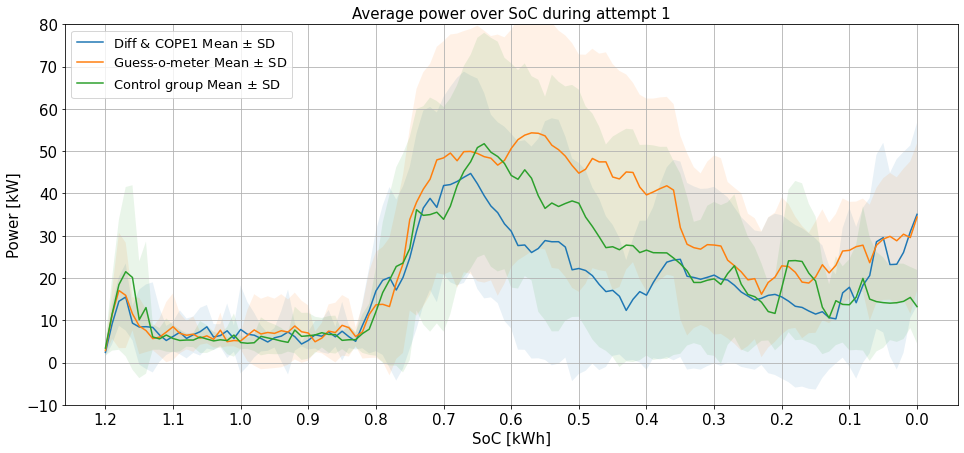

In [14]:
def plotGroupAverage(variable, attempt):
  variable_to_plot = variable
  attempt_nr = attempt

  fig, ax = plt.subplots(figsize=(16,7))

  # plot mean
  diff_cope_mean = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == attempt_nr)]
  plt.plot(diff_cope_mean["normalizing_window"], diff_cope_mean[variable_to_plot], label="Diff & COPE1 Mean $\pm$ SD")
  
  guess_o_meter_mean = average_groups[(average_groups.evis_id == "guess_o_meter") & (average_groups.attempt == attempt_nr)]
  plt.plot(guess_o_meter_mean["normalizing_window"], guess_o_meter_mean[variable_to_plot], label="Guess-o-meter Mean $\pm$ SD")
  
  control_group_mean = average_groups[(average_groups.evis_id == "control_group") & (average_groups.attempt == attempt_nr)]
  plt.plot(control_group_mean["normalizing_window"], control_group_mean[variable_to_plot], label="Control group Mean $\pm$ SD")
  
  # plot STD
  plt.gca().set_prop_cycle(None) # Restarts the color cycle
  std_alpha = 0.1
  
  diff_group_std = std_groups[(std_groups.evis_id == "diff_and_cope1") & (std_groups.attempt == attempt_nr)]
  plt.fill_between(
    diff_cope_mean["normalizing_window"], 
    diff_cope_mean[variable_to_plot] + diff_group_std[variable_to_plot],
    diff_cope_mean[variable_to_plot] - diff_group_std[variable_to_plot],
    alpha=std_alpha)
  
  guess_o_meter_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "guess_o_meter")]
  plt.fill_between(
    guess_o_meter_mean["normalizing_window"], 
    guess_o_meter_mean[variable_to_plot] + guess_o_meter_std[variable_to_plot],
    guess_o_meter_mean[variable_to_plot] - guess_o_meter_std[variable_to_plot],
    alpha=std_alpha)
  
  control_group_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "control_group")]
  plt.fill_between(
    control_group_mean["normalizing_window"], 
    control_group_mean[variable_to_plot] + control_group_std[variable_to_plot],
    control_group_mean[variable_to_plot] - control_group_std[variable_to_plot],
    alpha=std_alpha)

  # plot fails
  plt.gca().set_prop_cycle(None)
  
  
  # Set figure title
  tb1 = variables_print_pretty[variable_to_plot].lower()
  tb2 = str(attempt)
  ax.set_title("Average " + tb1 + " over SoC during attempt " + tb2)
  
  # Set the y-lim based on what variable we are plotting
  if variable_to_plot == "speed":
    ax.set_ylim(0,130)
  if variable_to_plot == "power_usage":
    ax.set_ylim(-10,80)
  if variable_to_plot == "throttle_position":
    ax.set_ylim(0,105)
 
  #road_evel_ax.legend()
  ax.legend(loc="upper left")  
  #ax.legend()  
  ax.grid(True)
  #ax.set_xlabel("Range estimate [km] (rounded down to whole number in EVIS)")
  ax.set_xlabel("SoC [kWh]")
  ax.set_ylabel(variables_print_pretty[variable_to_plot] + " " + variables_unit[variable_to_plot])
  
  ax.xaxis.set_minor_locator(MultipleLocator(100))
  ax.xaxis.grid(True, which='minor')
  
  ax.set_xticks(np.arange(0, 1.21, step=0.1))
  ax.invert_xaxis()


  title = "average_" + variables_print_pretty[variable_to_plot].lower() + "_against_SoC_attempt_" + str(attempt)
  #plt.savefig("/home/steve/Pictures/figures/only successful attempts/" + title + ".png", dpi=200)
  #title = "sample_distance_"+str(distance_window_size)+"m"
  #plt.savefig("/home/steve/Pictures/figures/31-3/" + title + ".png", dpi=200)

  plt.show()
  
  
variable = "speed"
#plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "power_usage"
plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "throttle_position"
#plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "current_soc"
#plotGroupAverage(variable, 1)

### Auto search for significance

In [15]:
def ttest_independent(samp_1, samp_2):
    # Check if equal variances
    s,p = stats.levene(samp_1, samp_2)
    equal_var = True
    if p < 0.05:
      equal_var = False
    
    s,p = stats.ttest_ind(samp_1, samp_2, equal_var=equal_var)
    
    return {
      "p": round(p,6),
      "N1": samp_1.count(),
      "N2": samp_2.count(),
      "samp1_mean": round(samp_1.mean(), 2),
      "samp2_mean": round(samp_2.mean(), 2)
    }
    
#variable = "throttle_position" 
variable = "power_usage" 
section_size = np.array([0,0.05])
step_size = 0.01
which_attempt = 1

significant_differences = []

section = section_size.copy()
while section[1] <= 1.21: # Battery capacity
    print(section)
    evis = "diff_and_cope1"
    individual = average_individual[(average_individual.attempt == which_attempt) & (average_individual.evis_id == evis)] # Get one particular attempt and evis values
    a1_mean_speeds_diff = individual.pivot(index="normalizing_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user

    evis = "guess_o_meter"
    individual = average_individual[(average_individual.attempt == which_attempt) & (average_individual.evis_id == evis)] # Get one particular attempt and evis values
    a1_mean_speeds_guess = individual.pivot(index="normalizing_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user

    evis = "control_group"
    individual = average_individual[(average_individual.attempt == which_attempt) & (average_individual.evis_id == evis)] # Get one particular attempt and evis values
    a1_mean_speeds_control = individual.pivot(index="normalizing_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user
  
    # Remove users who do not have data for the entire range and then calculate mean
    a1_mean_speeds_diff_section = a1_mean_speeds_diff.loc[section[0]:section[1]].dropna(axis=1).mean()
    a1_mean_speeds_guess_section = a1_mean_speeds_guess.loc[section[0]:section[1]].dropna(axis=1).mean()
    a1_mean_speeds_control_section = a1_mean_speeds_control.loc[section[0]:section[1]].dropna(axis=1).mean()
    
    t_test_control_guess = ttest_independent(a1_mean_speeds_control_section, a1_mean_speeds_guess_section)
    t_test_control_diff = ttest_independent(a1_mean_speeds_control_section, a1_mean_speeds_diff_section)
    t_test_diff_guess = ttest_independent(a1_mean_speeds_diff_section, a1_mean_speeds_guess_section)
    
    any_one_found = False
    if (t_test_control_diff["p"] < 0.05 or t_test_control_guess["p"] < 0.05 or  t_test_diff_guess["p"] < 0.05):
      any_one_found = True
    
    if any_one_found:
      if t_test_control_diff["p"] < 0.05:
        print("\t Found")
        significant_differences.append({
          "section":section.copy(), 
          "which":"control & diff", 
          "p-value": t_test_control_diff["p"], 
          "N Control": t_test_control_diff["N1"], 
          "N diff + COPE1": t_test_control_diff["N2"],
          "control mean": t_test_control_diff["samp1_mean"],
          "diff mean": t_test_control_diff["samp2_mean"]
        })
      
    if any_one_found:
      if t_test_control_guess["p"] < 0.05:
        print("\t Found")
        significant_differences.append({
          "section":section.copy(), 
          "which":"control & guess", 
          "p-value": t_test_control_guess["p"],
          "N control": t_test_control_guess["N1"],
          "N guess": t_test_control_guess["N2"],
          "control mean": t_test_control_diff["samp1_mean"],
          "guess mean": t_test_control_diff["samp2_mean"]
        })
    
    if any_one_found:
      if t_test_diff_guess["p"] < 0.05:
        print("\t Found")
        significant_differences.append({
          "section":section.copy(), 
          "which":"diff & guess", 
          "p-value": t_test_diff_guess["p"],
          "N diff + COPE1": t_test_diff_guess["N1"],
          "N guess": t_test_diff_guess["N2"],
          "diff mean": t_test_control_diff["samp1_mean"],
          "guess mean": t_test_control_diff["samp2_mean"]
        })
        
    #if any_one_found:
    #  print("-"*20)
    section += step_size      

[0.   0.05]
	 Found
[0.01 0.06]
	 Found
[0.02 0.07]
	 Found
[0.03 0.08]
	 Found
[0.04 0.09]
[0.05 0.1 ]
	 Found
[0.06 0.11]
	 Found
[0.07 0.12]
	 Found
[0.08 0.13]
	 Found
	 Found
[0.09 0.14]
	 Found
	 Found
[0.1  0.15]
	 Found
[0.11 0.16]
[0.12 0.17]
[0.13 0.18]
[0.14 0.19]
[0.15 0.2 ]
[0.16 0.21]
[0.17 0.22]
[0.18 0.23]
[0.19 0.24]
[0.2  0.25]
[0.21 0.26]
[0.22 0.27]
[0.23 0.28]
[0.24 0.29]
[0.25 0.3 ]
[0.26 0.31]
[0.27 0.32]
[0.28 0.33]
[0.29 0.34]
[0.3  0.35]
[0.31 0.36]
[0.32 0.37]
[0.33 0.38]
[0.34 0.39]
	 Found
[0.35 0.4 ]
	 Found
[0.36 0.41]
	 Found
[0.37 0.42]
	 Found
[0.38 0.43]
	 Found
[0.39 0.44]
	 Found
[0.4  0.45]
	 Found
[0.41 0.46]
	 Found
[0.42 0.47]
	 Found
[0.43 0.48]
	 Found
[0.44 0.49]
	 Found
[0.45 0.5 ]
	 Found
[0.46 0.51]
	 Found
[0.47 0.52]
	 Found
[0.48 0.53]
	 Found
[0.49 0.54]
	 Found
[0.5  0.55]
	 Found
[0.51 0.56]
	 Found
[0.52 0.57]
	 Found
[0.53 0.58]
	 Found
[0.54 0.59]
	 Found
[0.55 0.6 ]
	 Found
[0.56 0.61]
	 Found
[0.57 0.62]
[0.58 0.63]
[0.59 0.64]


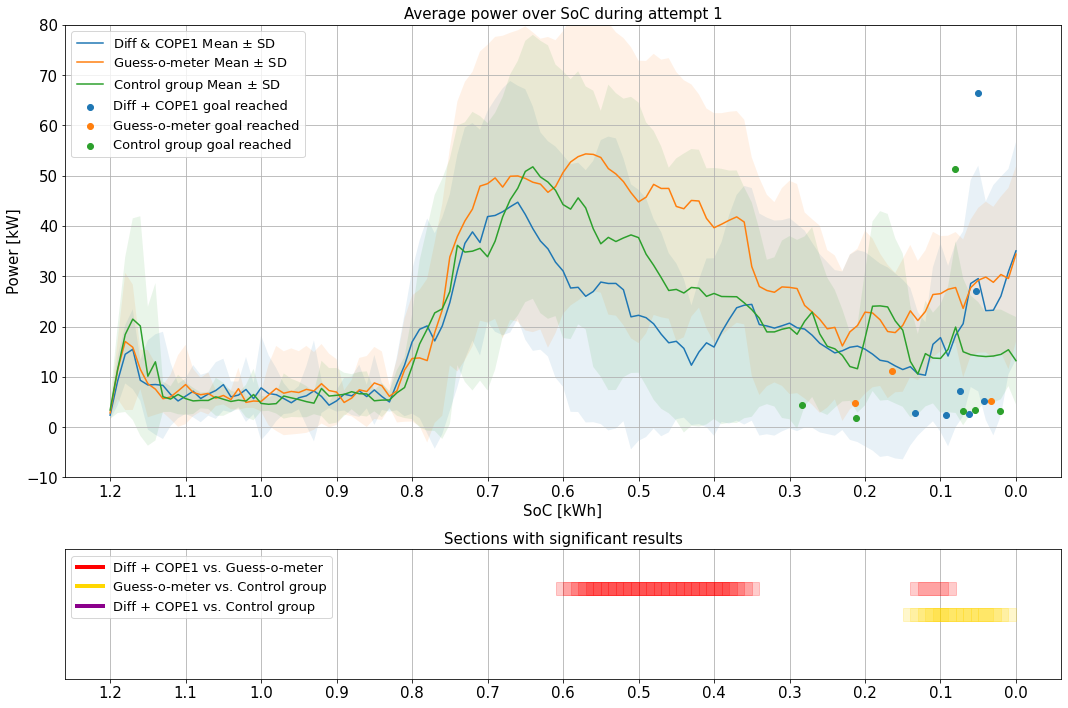

In [107]:
def plotGroupAverage(variable, attempt):
  variable_to_plot = variable
  attempt_nr = attempt

  fig, (ax, ax2) = plt.subplots(2,1,figsize=(15,10),gridspec_kw={'height_ratios': [3.5, 1]})

  # plot mean
  diff_cope_mean = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == attempt_nr)]
  ax.plot(diff_cope_mean["normalizing_window"], diff_cope_mean[variable_to_plot], label="Diff & COPE1 Mean $\pm$ SD")
  
  guess_o_meter_mean = average_groups[(average_groups.evis_id == "guess_o_meter") & (average_groups.attempt == attempt_nr)]
  ax.plot(guess_o_meter_mean["normalizing_window"], guess_o_meter_mean[variable_to_plot], label="Guess-o-meter Mean $\pm$ SD")
  
  control_group_mean = average_groups[(average_groups.evis_id == "control_group") & (average_groups.attempt == attempt_nr)]
  ax.plot(control_group_mean["normalizing_window"], control_group_mean[variable_to_plot], label="Control group Mean $\pm$ SD")
  
  # plot STD
  plt.gca().set_prop_cycle(None) # Restarts the color cycle
  std_alpha = 0.1
  
  diff_group_std = std_groups[(std_groups.evis_id == "diff_and_cope1") & (std_groups.attempt == attempt_nr)]
  ax.fill_between(
    diff_cope_mean["normalizing_window"], 
    diff_cope_mean[variable_to_plot] + diff_group_std[variable_to_plot],
    diff_cope_mean[variable_to_plot] - diff_group_std[variable_to_plot],
    alpha=std_alpha)
  
  guess_o_meter_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "guess_o_meter")]
  ax.fill_between(
    guess_o_meter_mean["normalizing_window"], 
    guess_o_meter_mean[variable_to_plot] + guess_o_meter_std[variable_to_plot],
    guess_o_meter_mean[variable_to_plot] - guess_o_meter_std[variable_to_plot],
    alpha=std_alpha)
  
  control_group_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "control_group")]
  ax.fill_between(
    control_group_mean["normalizing_window"], 
    control_group_mean[variable_to_plot] + control_group_std[variable_to_plot],
    control_group_mean[variable_to_plot] - control_group_std[variable_to_plot],
    alpha=std_alpha)

  ax.set_prop_cycle(None)
  
  diff_cope_goal_reached = average_individual_successful[(average_individual_successful.evis_id == "diff_and_cope1") & (average_individual_successful.attempt == 1)].groupby(["user_id"]).head(1)
  ax.scatter(diff_cope_goal_reached[variable_to_normalize_against], diff_cope_goal_reached[variable_to_plot], label="Diff + COPE1 goal reached")
  
  
  diff_cope_goal_reached = average_individual_successful[(average_individual_successful.evis_id == "guess_o_meter") & (average_individual_successful.attempt == 1)].groupby(["user_id"]).head(1)
  ax.scatter(diff_cope_goal_reached[variable_to_normalize_against], diff_cope_goal_reached[variable_to_plot], label="Guess-o-meter goal reached")
  
  
  diff_cope_goal_reached = average_individual_successful[(average_individual_successful.evis_id == "control_group") & (average_individual_successful.attempt == 1)].groupby(["user_id"]).head(1)
  ax.scatter(diff_cope_goal_reached[variable_to_normalize_against], diff_cope_goal_reached[variable_to_plot], label="Control group goal reached")
  
  
  # Set figure title
  tb1 = variables_print_pretty[variable_to_plot].lower()
  tb2 = str(attempt)
  ax.set_title("Average " + tb1 + " over SoC during attempt " + tb2)
  
  # Set the y-lim based on what variable we are plotting
  if variable_to_plot == "speed":
    ax.set_ylim(0,130)
  if variable_to_plot == "power_usage":
    ax.set_ylim(-10,80)
  if variable_to_plot == "throttle_position":
    ax.set_ylim(0,105)
 
  #road_evel_ax.legend()
  ax.legend(loc="upper left")  
  #ax.legend()  
  ax.grid(True)
  #ax.set_xlabel("Range estimate [km] (rounded down to whole number in EVIS)")
  ax.set_xlabel("SoC [kWh]")
  ax.set_ylabel(variables_print_pretty[variable_to_plot] + " " + variables_unit[variable_to_plot])
  
  ax.xaxis.set_minor_locator(MultipleLocator(100))
  ax.xaxis.grid(True, which='minor')
  
  ax.set_xticks(np.arange(0, 1.21, step=0.1))
  ax.invert_xaxis()


  ### Show significant differences ###
  thicknes = 0.1
  spacing = 0.1
  start_y_base = 0.25
  ax2.set_xlim(-400,8400)
  ax2.get_yaxis().set_visible(False)
  ax2.grid(True)
  padding = 0.06
  ax2.set_xlim(0-padding,1.2+padding)
  ax2.set_xticks(np.arange(0, 1.21, step=0.1))
  ax2.set_title("Sections with significant results")
  ax2.invert_xaxis()
  
  for difference in significant_differences:
    if difference["which"] == "control & diff":
      color = "darkmagenta"
      start_y = start_y_base
    if difference["which"] == "control & guess":
      color = "gold"
      start_y = start_y_base + thicknes + spacing
    if difference["which"] == "diff & guess":
      color = "red"
      start_y = start_y_base + (thicknes + spacing) * 2
    
    start_x = difference["section"][0]
    end_x = difference["section"][1]
    
    end_y = start_y + thicknes
    
    rect = Rectangle((start_x, start_y), 
                 end_x-start_x, end_y-start_y, 
                 fill=True, 
                 zorder=100,
                 alpha=0.2,
                 color=color)
    
    ax2.add_patch(rect)  
  
  custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="gold", lw=4),
                Line2D([0], [0], color="darkmagenta", lw=4)]
  ax2.legend(custom_lines, 
             ['Diff + COPE1 vs. Guess-o-meter', 'Guess-o-meter vs. Control group', 'Diff + COPE1 vs. Control group'],
            loc="upper left")
  ax.legend(loc="upper left")
  
  plt.tight_layout()
  #plt.savefig("/home/steve/Pictures/figures/20-4/power_over_soc_search.png", dpi=200)  
  plt.show()
  
  
variable = "speed"
#plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "power_usage"
plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "throttle_position"
#plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "current_soc"
#plotGroupAverage(variable, 1)

In [34]:
for x in significant_differences:
  print(x)

{'section': array([0. , 0.1]), 'which': 'control & guess', 'p-value': 0.012775, 'N control': 7, 'N guess': 11, 'control mean': 17.74, 'guess mean': 22.91}
{'section': array([0.35, 0.45]), 'which': 'diff & guess', 'p-value': 0.003672, 'N diff + COPE1': 13, 'N guess': 14, 'diff mean': 26.06, 'guess mean': 18.84}
{'section': array([0.4, 0.5]), 'which': 'diff & guess', 'p-value': 0.001049, 'N diff + COPE1': 13, 'N guess': 14, 'diff mean': 28.55, 'guess mean': 17.03}
{'section': array([0.45, 0.55]), 'which': 'diff & guess', 'p-value': 0.010451, 'N diff + COPE1': 13, 'N guess': 14, 'diff mean': 33.9, 'guess mean': 22.33}
{'section': array([0.5, 0.6]), 'which': 'diff & guess', 'p-value': 0.025746, 'N diff + COPE1': 13, 'N guess': 14, 'diff mean': 40.07, 'guess mean': 27.0}


### Significance for specific sections

In [108]:
sections = [
  [0.05, 0.9],
  [0.0, 0.165],
  [0.45, 0.65]
]

In [109]:
def ttest_independent(samp_1, samp_2):
    # Check if equal variances
    s,p = stats.levene(samp_1, samp_2)
    equal_var = True
    if p < 0.05:
      equal_var = False
    
    s,p = stats.ttest_ind(samp_1, samp_2, equal_var=equal_var)
    
    return {
      "p": round(p,6),
      "N1": samp_1.count(),
      "N2": samp_2.count(),
      "samp1_mean": round(samp_1.mean(), 2),
      "samp2_mean": round(samp_2.mean(), 2)
    }
    
#variable = "throttle_position" 
variable = "power_usage" 
which_attempt = 1

significant_differences = []

section = section_size.copy()
for section in sections:
    print(section)
    evis = "diff_and_cope1"
    individual = average_individual[(average_individual.attempt == which_attempt) & (average_individual.evis_id == evis)] # Get one particular attempt and evis values
    a1_mean_speeds_diff = individual.pivot(index="normalizing_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user

    evis = "guess_o_meter"
    individual = average_individual[(average_individual.attempt == which_attempt) & (average_individual.evis_id == evis)] # Get one particular attempt and evis values
    a1_mean_speeds_guess = individual.pivot(index="normalizing_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user

    evis = "control_group"
    individual = average_individual[(average_individual.attempt == which_attempt) & (average_individual.evis_id == evis)] # Get one particular attempt and evis values
    a1_mean_speeds_control = individual.pivot(index="normalizing_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user
  
    # Remove users who do not have data for the entire range and then calculate mean
    a1_mean_speeds_diff_section = a1_mean_speeds_diff.loc[section[0]:section[1]].dropna(axis=1).mean()
    a1_mean_speeds_guess_section = a1_mean_speeds_guess.loc[section[0]:section[1]].dropna(axis=1).mean()
    a1_mean_speeds_control_section = a1_mean_speeds_control.loc[section[0]:section[1]].dropna(axis=1).mean()
    
    t_test_control_guess = ttest_independent(a1_mean_speeds_control_section, a1_mean_speeds_guess_section)
    t_test_control_diff = ttest_independent(a1_mean_speeds_control_section, a1_mean_speeds_diff_section)
    t_test_diff_guess = ttest_independent(a1_mean_speeds_diff_section, a1_mean_speeds_guess_section)
    
    any_one_found = False
    if (t_test_control_diff["p"] < 0.05 or t_test_control_guess["p"] < 0.05 or  t_test_diff_guess["p"] < 0.05):
      any_one_found = True
    
    if any_one_found:
      if t_test_control_diff["p"] < 0.05:
        print("\t Found")
        significant_differences.append({
          "section":section.copy(), 
          "which":"control & diff", 
          "p-value": t_test_control_diff["p"], 
          "N Control": t_test_control_diff["N1"], 
          "N diff + COPE1": t_test_control_diff["N2"],
          "control mean": t_test_control_diff["samp1_mean"],
          "diff mean": t_test_control_diff["samp2_mean"]
        })
      
    if any_one_found:
      if t_test_control_guess["p"] < 0.05:
        print("\t Found")
        significant_differences.append({
          "section":section.copy(), 
          "which":"control & guess", 
          "p-value": t_test_control_guess["p"],
          "N control": t_test_control_guess["N1"],
          "N guess": t_test_control_guess["N2"],
          "control mean": t_test_control_diff["samp1_mean"],
          "guess mean": t_test_control_diff["samp2_mean"]
        })
    
    if any_one_found:
      if t_test_diff_guess["p"] < 0.05:
        print("\t Found")
        significant_differences.append({
          "section":section.copy(), 
          "which":"diff & guess", 
          "p-value": t_test_diff_guess["p"],
          "N diff + COPE1": t_test_diff_guess["N1"],
          "N guess": t_test_diff_guess["N2"],
          "diff mean": t_test_control_diff["samp1_mean"],
          "guess mean": t_test_control_diff["samp2_mean"]
        })

[0.05, 0.9]
	 Found
[0.0, 0.165]
	 Found
[0.45, 0.65]
	 Found


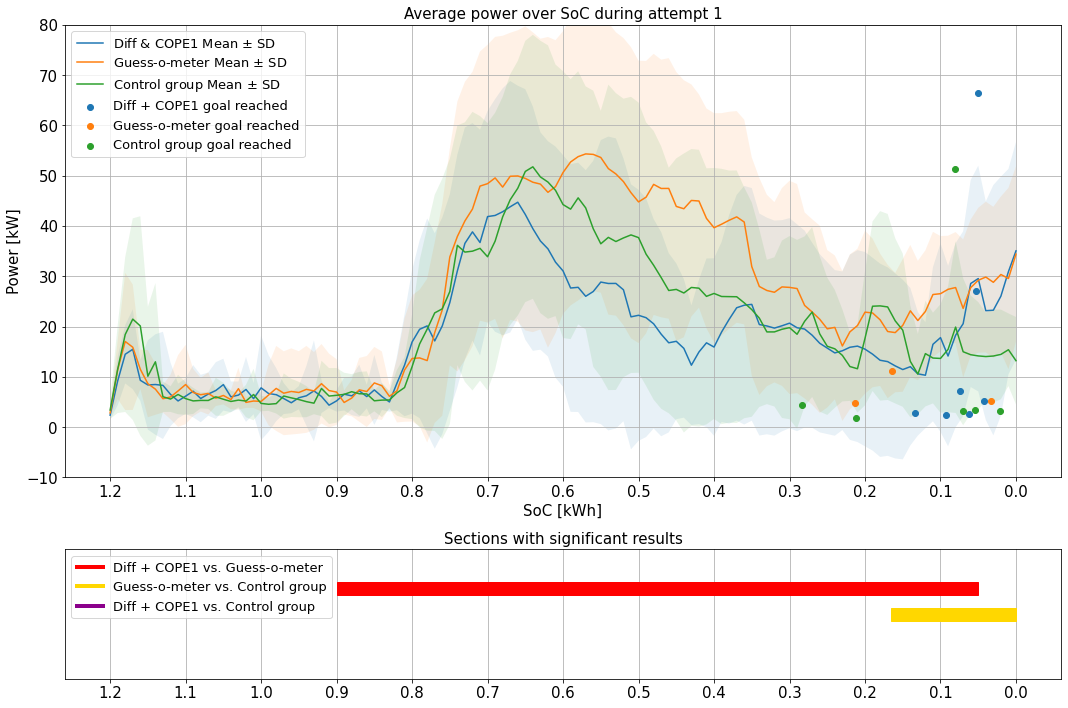

In [111]:
def plotGroupAverage(variable, attempt):
  variable_to_plot = variable
  attempt_nr = attempt

  fig, (ax, ax2) = plt.subplots(2,1,figsize=(15,10),gridspec_kw={'height_ratios': [3.5, 1]})

  # plot mean
  diff_cope_mean = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == attempt_nr)]
  ax.plot(diff_cope_mean["normalizing_window"], diff_cope_mean[variable_to_plot], label="Diff & COPE1 Mean $\pm$ SD")
  
  guess_o_meter_mean = average_groups[(average_groups.evis_id == "guess_o_meter") & (average_groups.attempt == attempt_nr)]
  ax.plot(guess_o_meter_mean["normalizing_window"], guess_o_meter_mean[variable_to_plot], label="Guess-o-meter Mean $\pm$ SD")
  
  control_group_mean = average_groups[(average_groups.evis_id == "control_group") & (average_groups.attempt == attempt_nr)]
  ax.plot(control_group_mean["normalizing_window"], control_group_mean[variable_to_plot], label="Control group Mean $\pm$ SD")
  
  # plot STD
  plt.gca().set_prop_cycle(None) # Restarts the color cycle
  std_alpha = 0.1
  
  diff_group_std = std_groups[(std_groups.evis_id == "diff_and_cope1") & (std_groups.attempt == attempt_nr)]
  ax.fill_between(
    diff_cope_mean["normalizing_window"], 
    diff_cope_mean[variable_to_plot] + diff_group_std[variable_to_plot],
    diff_cope_mean[variable_to_plot] - diff_group_std[variable_to_plot],
    alpha=std_alpha)
  
  guess_o_meter_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "guess_o_meter")]
  ax.fill_between(
    guess_o_meter_mean["normalizing_window"], 
    guess_o_meter_mean[variable_to_plot] + guess_o_meter_std[variable_to_plot],
    guess_o_meter_mean[variable_to_plot] - guess_o_meter_std[variable_to_plot],
    alpha=std_alpha)
  
  control_group_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "control_group")]
  ax.fill_between(
    control_group_mean["normalizing_window"], 
    control_group_mean[variable_to_plot] + control_group_std[variable_to_plot],
    control_group_mean[variable_to_plot] - control_group_std[variable_to_plot],
    alpha=std_alpha)

  ax.set_prop_cycle(None)
  
  diff_cope_goal_reached = average_individual_successful[(average_individual_successful.evis_id == "diff_and_cope1") & (average_individual_successful.attempt == 1)].groupby(["user_id"]).head(1)
  ax.scatter(diff_cope_goal_reached[variable_to_normalize_against], diff_cope_goal_reached[variable_to_plot], label="Diff + COPE1 goal reached")
  
  
  diff_cope_goal_reached = average_individual_successful[(average_individual_successful.evis_id == "guess_o_meter") & (average_individual_successful.attempt == 1)].groupby(["user_id"]).head(1)
  ax.scatter(diff_cope_goal_reached[variable_to_normalize_against], diff_cope_goal_reached[variable_to_plot], label="Guess-o-meter goal reached")
  
  
  diff_cope_goal_reached = average_individual_successful[(average_individual_successful.evis_id == "control_group") & (average_individual_successful.attempt == 1)].groupby(["user_id"]).head(1)
  ax.scatter(diff_cope_goal_reached[variable_to_normalize_against], diff_cope_goal_reached[variable_to_plot], label="Control group goal reached")
  
  
  
  # Set figure title
  tb1 = variables_print_pretty[variable_to_plot].lower()
  tb2 = str(attempt)
  ax.set_title("Average " + tb1 + " over SoC during attempt " + tb2)
  
  # Set the y-lim based on what variable we are plotting
  if variable_to_plot == "speed":
    ax.set_ylim(0,130)
  if variable_to_plot == "power_usage":
    ax.set_ylim(-10,80)
  if variable_to_plot == "throttle_position":
    ax.set_ylim(0,105)
 
  #road_evel_ax.legend()
  ax.legend(loc="upper left")  
  #ax.legend()  
  ax.grid(True)
  #ax.set_xlabel("Range estimate [km] (rounded down to whole number in EVIS)")
  ax.set_xlabel("SoC [kWh]")
  ax.set_ylabel(variables_print_pretty[variable_to_plot] + " " + variables_unit[variable_to_plot])
  
  ax.xaxis.set_minor_locator(MultipleLocator(100))
  ax.xaxis.grid(True, which='minor')
  
  ax.set_xticks(np.arange(0, 1.21, step=0.1))
  ax.invert_xaxis()


  ### Show significant differences ###
  thicknes = 0.1
  spacing = 0.1
  start_y_base = 0.25
  ax2.set_xlim(-400,8400)
  ax2.get_yaxis().set_visible(False)
  ax2.grid(True)
  padding = 0.06
  ax2.set_xlim(0-padding,1.2+padding)
  ax2.set_xticks(np.arange(0, 1.21, step=0.1))
  ax2.set_title("Sections with significant results")
  ax2.invert_xaxis()
  
  for difference in significant_differences:
    if difference["which"] == "control & diff":
      color = "darkmagenta"
      start_y = start_y_base
    if difference["which"] == "control & guess":
      color = "gold"
      start_y = start_y_base + thicknes + spacing
    if difference["which"] == "diff & guess":
      color = "red"
      start_y = start_y_base + (thicknes + spacing) * 2
    
    start_x = difference["section"][0]
    end_x = difference["section"][1]
    
    end_y = start_y + thicknes
    
    rect = Rectangle((start_x, start_y), 
                 end_x-start_x, end_y-start_y, 
                 fill=True, 
                 zorder=100,
                 alpha=1.0,
                 color=color)
    
    ax2.add_patch(rect)  
  
  custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="gold", lw=4),
                Line2D([0], [0], color="darkmagenta", lw=4)]
  ax2.legend(custom_lines, 
             ['Diff + COPE1 vs. Guess-o-meter', 'Guess-o-meter vs. Control group', 'Diff + COPE1 vs. Control group'],
            loc="upper left")
  ax.legend(loc="upper left")
  
  plt.tight_layout()
  #plt.savefig("/home/steve/Pictures/figures/20-4/power_over_soc_specific_sections.png", dpi=200)  
  plt.show()
  
  
variable = "speed"
#plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "power_usage"
plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "throttle_position"
#plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "current_soc"
#plotGroupAverage(variable, 1)

In [97]:
for x in significant_differences:
  print(x)

{'section': [0.05, 0.9], 'which': 'diff & guess', 'p-value': 0.007281, 'N diff + COPE1': 9, 'N guess': 12, 'diff mean': 29.18, 'guess mean': 22.63}
{'section': [0.0, 0.165], 'which': 'control & guess', 'p-value': 0.038122, 'N control': 7, 'N guess': 11, 'control mean': 18.68, 'guess mean': 21.48}
{'section': [0.45, 0.65], 'which': 'diff & guess', 'p-value': 0.026826, 'N diff + COPE1': 13, 'N guess': 14, 'diff mean': 39.99, 'guess mean': 27.55}


## Group averages (SPEED)

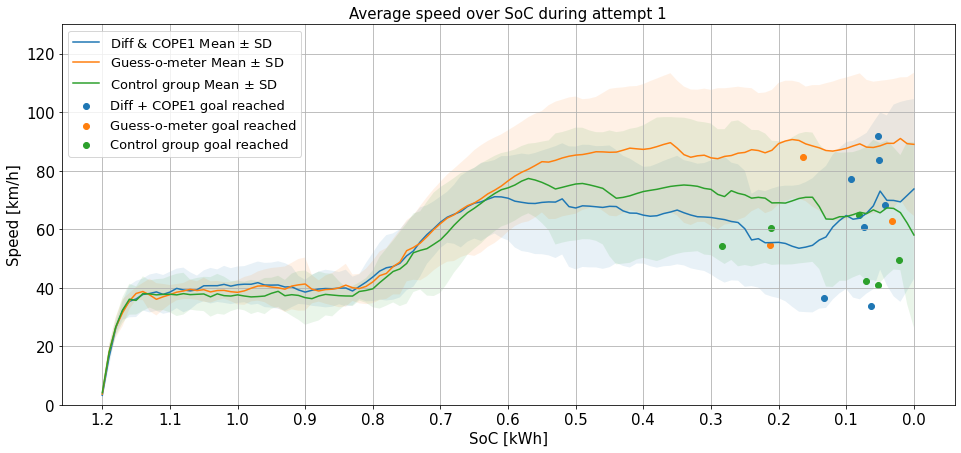

In [112]:
def plotGroupAverage(variable, attempt):
  variable_to_plot = variable
  attempt_nr = attempt

  fig, ax = plt.subplots(figsize=(16,7))

  # plot mean
  diff_cope_mean = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == attempt_nr)]
  plt.plot(diff_cope_mean["normalizing_window"], diff_cope_mean[variable_to_plot], label="Diff & COPE1 Mean $\pm$ SD")
  
  guess_o_meter_mean = average_groups[(average_groups.evis_id == "guess_o_meter") & (average_groups.attempt == attempt_nr)]
  plt.plot(guess_o_meter_mean["normalizing_window"], guess_o_meter_mean[variable_to_plot], label="Guess-o-meter Mean $\pm$ SD")
  
  control_group_mean = average_groups[(average_groups.evis_id == "control_group") & (average_groups.attempt == attempt_nr)]
  plt.plot(control_group_mean["normalizing_window"], control_group_mean[variable_to_plot], label="Control group Mean $\pm$ SD")
  
  # plot STD
  plt.gca().set_prop_cycle(None) # Restarts the color cycle
  std_alpha = 0.1
  
  diff_group_std = std_groups[(std_groups.evis_id == "diff_and_cope1") & (std_groups.attempt == attempt_nr)]
  plt.fill_between(
    diff_cope_mean["normalizing_window"], 
    diff_cope_mean[variable_to_plot] + diff_group_std[variable_to_plot],
    diff_cope_mean[variable_to_plot] - diff_group_std[variable_to_plot],
    alpha=std_alpha)
  
  guess_o_meter_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "guess_o_meter")]
  plt.fill_between(
    guess_o_meter_mean["normalizing_window"], 
    guess_o_meter_mean[variable_to_plot] + guess_o_meter_std[variable_to_plot],
    guess_o_meter_mean[variable_to_plot] - guess_o_meter_std[variable_to_plot],
    alpha=std_alpha)
  
  control_group_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "control_group")]
  plt.fill_between(
    control_group_mean["normalizing_window"], 
    control_group_mean[variable_to_plot] + control_group_std[variable_to_plot],
    control_group_mean[variable_to_plot] - control_group_std[variable_to_plot],
    alpha=std_alpha)

  ax.set_prop_cycle(None)
  
  diff_cope_goal_reached = average_individual_successful[(average_individual_successful.evis_id == "diff_and_cope1") & (average_individual_successful.attempt == 1)].groupby(["user_id"]).head(1)
  ax.scatter(diff_cope_goal_reached[variable_to_normalize_against], diff_cope_goal_reached[variable_to_plot], label="Diff + COPE1 goal reached")
  
  
  diff_cope_goal_reached = average_individual_successful[(average_individual_successful.evis_id == "guess_o_meter") & (average_individual_successful.attempt == 1)].groupby(["user_id"]).head(1)
  ax.scatter(diff_cope_goal_reached[variable_to_normalize_against], diff_cope_goal_reached[variable_to_plot], label="Guess-o-meter goal reached")
  
  
  diff_cope_goal_reached = average_individual_successful[(average_individual_successful.evis_id == "control_group") & (average_individual_successful.attempt == 1)].groupby(["user_id"]).head(1)
  ax.scatter(diff_cope_goal_reached[variable_to_normalize_against], diff_cope_goal_reached[variable_to_plot], label="Control group goal reached")
  
  
  
  # Set figure title
  tb1 = variables_print_pretty[variable_to_plot].lower()
  tb2 = str(attempt)
  ax.set_title("Average " + tb1 + " over SoC during attempt " + tb2)
  
  # Set the y-lim based on what variable we are plotting
  if variable_to_plot == "speed":
    ax.set_ylim(0,130)
  if variable_to_plot == "power_usage":
    ax.set_ylim(-10,80)
  if variable_to_plot == "throttle_position":
    ax.set_ylim(0,105)
 
  #road_evel_ax.legend()
  ax.legend(loc="upper left")  
  #ax.legend()  
  ax.grid(True)
  #ax.set_xlabel("Range estimate [km] (rounded down to whole number in EVIS)")
  ax.set_xlabel("SoC [kWh]")
  ax.set_ylabel(variables_print_pretty[variable_to_plot] + " " + variables_unit[variable_to_plot])
  
  ax.xaxis.set_minor_locator(MultipleLocator(100))
  ax.xaxis.grid(True, which='minor')
  
  ax.set_xticks(np.arange(0, 1.21, step=0.1))
  ax.invert_xaxis()


  title = "average_" + variables_print_pretty[variable_to_plot].lower() + "_against_SoC_attempt_" + str(attempt)
  #plt.savefig("/home/steve/Pictures/figures/only successful attempts/" + title + ".png", dpi=200)
  #title = "sample_distance_"+str(distance_window_size)+"m"
  #plt.savefig("/home/steve/Pictures/figures/31-3/" + title + ".png", dpi=200)

  plt.show()
  
  
variable = "speed"
plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "power_usage"
#plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "throttle_position"
#plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "current_soc"
#plotGroupAverage(variable, 1)

### Auto search for significance

In [113]:
def ttest_independent(samp_1, samp_2):
    # Check if equal variances
    s,p = stats.levene(samp_1, samp_2)
    equal_var = True
    if p < 0.05:
      equal_var = False
    
    s,p = stats.ttest_ind(samp_1, samp_2, equal_var=equal_var)
    
    return {
      "p": round(p,6),
      "N1": samp_1.count(),
      "N2": samp_2.count(),
      "samp1_mean": round(samp_1.mean(), 2),
      "samp2_mean": round(samp_2.mean(), 2)
    }
    
#variable = "throttle_position" 
variable = "speed" 
section_size = np.array([0,0.05])
step_size = 0.01
which_attempt = 1

significant_differences = []

section = section_size.copy()
while section[1] <= 1.21: # Battery capacity
    print(section)
    evis = "diff_and_cope1"
    individual = average_individual[(average_individual.attempt == which_attempt) & (average_individual.evis_id == evis)] # Get one particular attempt and evis values
    a1_mean_speeds_diff = individual.pivot(index="normalizing_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user

    evis = "guess_o_meter"
    individual = average_individual[(average_individual.attempt == which_attempt) & (average_individual.evis_id == evis)] # Get one particular attempt and evis values
    a1_mean_speeds_guess = individual.pivot(index="normalizing_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user

    evis = "control_group"
    individual = average_individual[(average_individual.attempt == which_attempt) & (average_individual.evis_id == evis)] # Get one particular attempt and evis values
    a1_mean_speeds_control = individual.pivot(index="normalizing_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user
  
    # Remove users who do not have data for the entire range and then calculate mean
    a1_mean_speeds_diff_section = a1_mean_speeds_diff.loc[section[0]:section[1]].dropna(axis=1).mean()
    a1_mean_speeds_guess_section = a1_mean_speeds_guess.loc[section[0]:section[1]].dropna(axis=1).mean()
    a1_mean_speeds_control_section = a1_mean_speeds_control.loc[section[0]:section[1]].dropna(axis=1).mean()
    
    t_test_control_guess = ttest_independent(a1_mean_speeds_control_section, a1_mean_speeds_guess_section)
    t_test_control_diff = ttest_independent(a1_mean_speeds_control_section, a1_mean_speeds_diff_section)
    t_test_diff_guess = ttest_independent(a1_mean_speeds_diff_section, a1_mean_speeds_guess_section)
    
    any_one_found = False
    if (t_test_control_diff["p"] < 0.05 or t_test_control_guess["p"] < 0.05 or  t_test_diff_guess["p"] < 0.05):
      any_one_found = True
    
    if any_one_found:
      if t_test_control_diff["p"] < 0.05:
        print("\t Found")
        significant_differences.append({
          "section":section.copy(), 
          "which":"control & diff", 
          "p-value": t_test_control_diff["p"], 
          "N Control": t_test_control_diff["N1"], 
          "N diff + COPE1": t_test_control_diff["N2"],
          "control mean": t_test_control_diff["samp1_mean"],
          "diff mean": t_test_control_diff["samp2_mean"]
        })
      
    if any_one_found:
      if t_test_control_guess["p"] < 0.05:
        print("\t Found")
        significant_differences.append({
          "section":section.copy(), 
          "which":"control & guess", 
          "p-value": t_test_control_guess["p"],
          "N control": t_test_control_guess["N1"],
          "N guess": t_test_control_guess["N2"],
          "control mean": t_test_control_diff["samp1_mean"],
          "guess mean": t_test_control_diff["samp2_mean"]
        })
    
    if any_one_found:
      if t_test_diff_guess["p"] < 0.05:
        print("\t Found")
        significant_differences.append({
          "section":section.copy(), 
          "which":"diff & guess", 
          "p-value": t_test_diff_guess["p"],
          "N diff + COPE1": t_test_diff_guess["N1"],
          "N guess": t_test_diff_guess["N2"],
          "diff mean": t_test_control_diff["samp1_mean"],
          "guess mean": t_test_control_diff["samp2_mean"]
        })
        
    #if any_one_found:
    #  print("-"*20)
    section += step_size      

[0.   0.05]
	 Found
[0.01 0.06]
[0.02 0.07]
	 Found
[0.03 0.08]
[0.04 0.09]
[0.05 0.1 ]
[0.06 0.11]
	 Found
	 Found
[0.07 0.12]
	 Found
	 Found
[0.08 0.13]
	 Found
	 Found
[0.09 0.14]
	 Found
	 Found
[0.1  0.15]
	 Found
	 Found
[0.11 0.16]
	 Found
	 Found
[0.12 0.17]
	 Found
	 Found
[0.13 0.18]
	 Found
	 Found
[0.14 0.19]
	 Found
	 Found
[0.15 0.2 ]
	 Found
	 Found
[0.16 0.21]
	 Found
	 Found
[0.17 0.22]
	 Found
	 Found
[0.18 0.23]
	 Found
	 Found
[0.19 0.24]
	 Found
	 Found
[0.2  0.25]
	 Found
[0.21 0.26]
	 Found
[0.22 0.27]
	 Found
[0.23 0.28]
	 Found
[0.24 0.29]
	 Found
[0.25 0.3 ]
	 Found
[0.26 0.31]
	 Found
[0.27 0.32]
	 Found
[0.28 0.33]
	 Found
[0.29 0.34]
	 Found
[0.3  0.35]
	 Found
[0.31 0.36]
	 Found
[0.32 0.37]
	 Found
[0.33 0.38]
	 Found
[0.34 0.39]
	 Found
[0.35 0.4 ]
	 Found
[0.36 0.41]
	 Found
[0.37 0.42]
	 Found
[0.38 0.43]
	 Found
[0.39 0.44]
	 Found
[0.4  0.45]
	 Found
[0.41 0.46]
	 Found
[0.42 0.47]
	 Found
[0.43 0.48]
	 Found
[0.44 0.49]
	 Found
[0.45 0.5 ]
	 Found


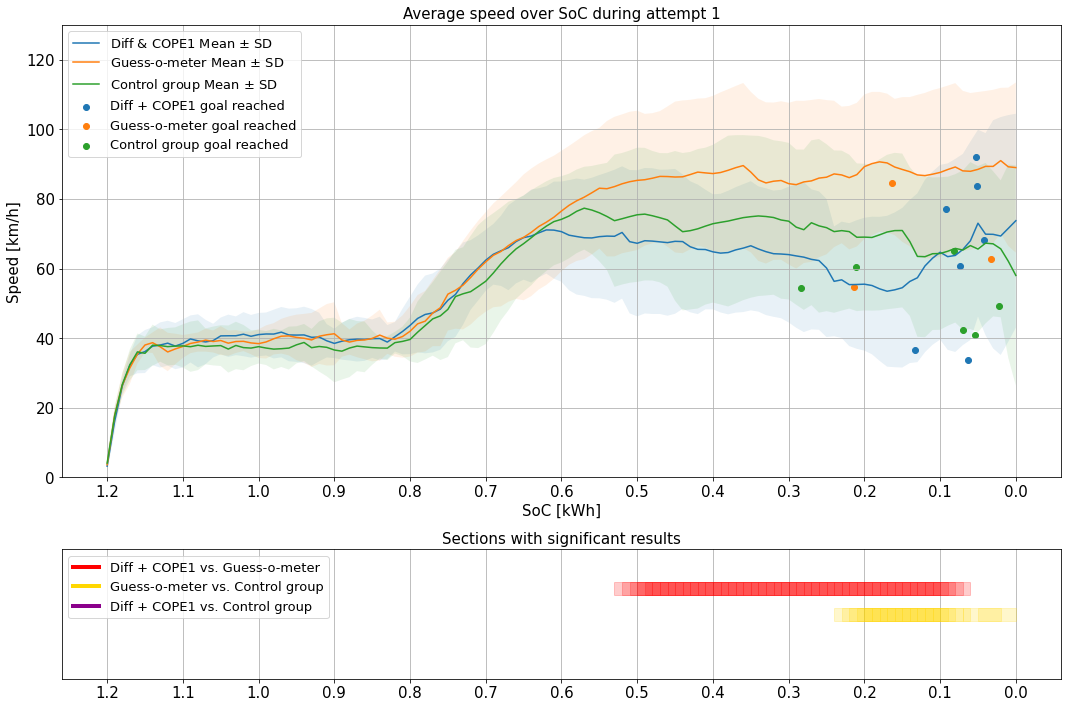

In [117]:
def plotGroupAverage(variable, attempt):
  variable_to_plot = variable
  attempt_nr = attempt

  fig, (ax, ax2) = plt.subplots(2,1,figsize=(15,10),gridspec_kw={'height_ratios': [3.5, 1]})

  # plot mean
  diff_cope_mean = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == attempt_nr)]
  ax.plot(diff_cope_mean["normalizing_window"], diff_cope_mean[variable_to_plot], label="Diff & COPE1 Mean $\pm$ SD")
  
  guess_o_meter_mean = average_groups[(average_groups.evis_id == "guess_o_meter") & (average_groups.attempt == attempt_nr)]
  ax.plot(guess_o_meter_mean["normalizing_window"], guess_o_meter_mean[variable_to_plot], label="Guess-o-meter Mean $\pm$ SD")
  
  control_group_mean = average_groups[(average_groups.evis_id == "control_group") & (average_groups.attempt == attempt_nr)]
  ax.plot(control_group_mean["normalizing_window"], control_group_mean[variable_to_plot], label="Control group Mean $\pm$ SD")
  
  # plot STD
  plt.gca().set_prop_cycle(None) # Restarts the color cycle
  std_alpha = 0.1
  
  diff_group_std = std_groups[(std_groups.evis_id == "diff_and_cope1") & (std_groups.attempt == attempt_nr)]
  ax.fill_between(
    diff_cope_mean["normalizing_window"], 
    diff_cope_mean[variable_to_plot] + diff_group_std[variable_to_plot],
    diff_cope_mean[variable_to_plot] - diff_group_std[variable_to_plot],
    alpha=std_alpha)
  
  guess_o_meter_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "guess_o_meter")]
  ax.fill_between(
    guess_o_meter_mean["normalizing_window"], 
    guess_o_meter_mean[variable_to_plot] + guess_o_meter_std[variable_to_plot],
    guess_o_meter_mean[variable_to_plot] - guess_o_meter_std[variable_to_plot],
    alpha=std_alpha)
  
  control_group_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "control_group")]
  ax.fill_between(
    control_group_mean["normalizing_window"], 
    control_group_mean[variable_to_plot] + control_group_std[variable_to_plot],
    control_group_mean[variable_to_plot] - control_group_std[variable_to_plot],
    alpha=std_alpha)

  ax.set_prop_cycle(None)
  
  diff_cope_goal_reached = average_individual_successful[(average_individual_successful.evis_id == "diff_and_cope1") & (average_individual_successful.attempt == 1)].groupby(["user_id"]).head(1)
  ax.scatter(diff_cope_goal_reached[variable_to_normalize_against], diff_cope_goal_reached[variable_to_plot], label="Diff + COPE1 goal reached")
  
  
  diff_cope_goal_reached = average_individual_successful[(average_individual_successful.evis_id == "guess_o_meter") & (average_individual_successful.attempt == 1)].groupby(["user_id"]).head(1)
  ax.scatter(diff_cope_goal_reached[variable_to_normalize_against], diff_cope_goal_reached[variable_to_plot], label="Guess-o-meter goal reached")
  
  
  diff_cope_goal_reached = average_individual_successful[(average_individual_successful.evis_id == "control_group") & (average_individual_successful.attempt == 1)].groupby(["user_id"]).head(1)
  ax.scatter(diff_cope_goal_reached[variable_to_normalize_against], diff_cope_goal_reached[variable_to_plot], label="Control group goal reached")
  
  
  # Set figure title
  tb1 = variables_print_pretty[variable_to_plot].lower()
  tb2 = str(attempt)
  ax.set_title("Average " + tb1 + " over SoC during attempt " + tb2)
  
  # Set the y-lim based on what variable we are plotting
  if variable_to_plot == "speed":
    ax.set_ylim(0,130)
  if variable_to_plot == "power_usage":
    ax.set_ylim(-10,80)
  if variable_to_plot == "throttle_position":
    ax.set_ylim(0,105)
 
  #road_evel_ax.legend()
  ax.legend(loc="upper left")  
  #ax.legend()  
  ax.grid(True)
  #ax.set_xlabel("Range estimate [km] (rounded down to whole number in EVIS)")
  ax.set_xlabel("SoC [kWh]")
  ax.set_ylabel(variables_print_pretty[variable_to_plot] + " " + variables_unit[variable_to_plot])
  
  ax.xaxis.set_minor_locator(MultipleLocator(100))
  ax.xaxis.grid(True, which='minor')
  
  ax.set_xticks(np.arange(0, 1.21, step=0.1))
  ax.invert_xaxis()


  ### Show significant differences ###
  thicknes = 0.1
  spacing = 0.1
  start_y_base = 0.25
  ax2.set_xlim(-400,8400)
  ax2.get_yaxis().set_visible(False)
  ax2.grid(True)
  padding = 0.06
  ax2.set_xlim(0-padding,1.2+padding)
  ax2.set_xticks(np.arange(0, 1.21, step=0.1))
  ax2.set_title("Sections with significant results")
  ax2.invert_xaxis()
  
  for difference in significant_differences:
    if difference["which"] == "control & diff":
      color = "darkmagenta"
      start_y = start_y_base
    if difference["which"] == "control & guess":
      color = "gold"
      start_y = start_y_base + thicknes + spacing
    if difference["which"] == "diff & guess":
      color = "red"
      start_y = start_y_base + (thicknes + spacing) * 2
    
    start_x = difference["section"][0]
    end_x = difference["section"][1]
    
    end_y = start_y + thicknes
    
    rect = Rectangle((start_x, start_y), 
                 end_x-start_x, end_y-start_y, 
                 fill=True, 
                 zorder=100,
                 alpha=0.2,
                 color=color)
    
    ax2.add_patch(rect)  
  
  custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="gold", lw=4),
                Line2D([0], [0], color="darkmagenta", lw=4)]
  ax2.legend(custom_lines, 
             ['Diff + COPE1 vs. Guess-o-meter', 'Guess-o-meter vs. Control group', 'Diff + COPE1 vs. Control group'],
            loc="upper left")
  ax.legend(loc="upper left")
  
  plt.tight_layout()
  #plt.savefig("/home/steve/Pictures/figures/20-4/speed_over_soc_search.png", dpi=200)  
  plt.show()
  
  
variable = "speed"
plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "power_usage"
#plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "throttle_position"
#plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "current_soc"
#plotGroupAverage(variable, 1)

## Group averages (THROTTLE)

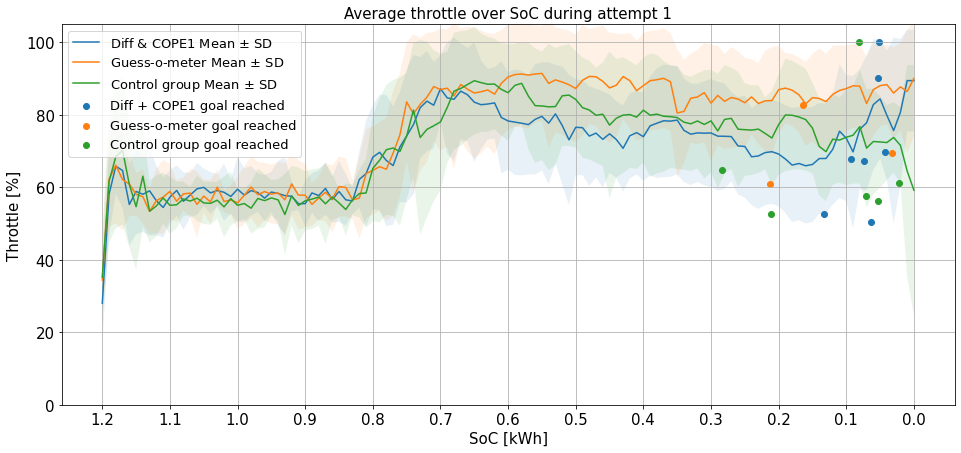

In [166]:
def plotGroupAverage(variable, attempt):
  variable_to_plot = variable
  attempt_nr = attempt

  fig, ax = plt.subplots(figsize=(16,7))

  # plot mean
  diff_cope_mean = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == attempt_nr)]
  plt.plot(diff_cope_mean["normalizing_window"], diff_cope_mean[variable_to_plot], label="Diff & COPE1 Mean $\pm$ SD")
  
  guess_o_meter_mean = average_groups[(average_groups.evis_id == "guess_o_meter") & (average_groups.attempt == attempt_nr)]
  plt.plot(guess_o_meter_mean["normalizing_window"], guess_o_meter_mean[variable_to_plot], label="Guess-o-meter Mean $\pm$ SD")
  
  control_group_mean = average_groups[(average_groups.evis_id == "control_group") & (average_groups.attempt == attempt_nr)]
  plt.plot(control_group_mean["normalizing_window"], control_group_mean[variable_to_plot], label="Control group Mean $\pm$ SD")
  
  # plot STD
  plt.gca().set_prop_cycle(None) # Restarts the color cycle
  std_alpha = 0.1
  
  diff_group_std = std_groups[(std_groups.evis_id == "diff_and_cope1") & (std_groups.attempt == attempt_nr)]
  plt.fill_between(
    diff_cope_mean["normalizing_window"], 
    diff_cope_mean[variable_to_plot] + diff_group_std[variable_to_plot],
    diff_cope_mean[variable_to_plot] - diff_group_std[variable_to_plot],
    alpha=std_alpha)
  
  guess_o_meter_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "guess_o_meter")]
  plt.fill_between(
    guess_o_meter_mean["normalizing_window"], 
    guess_o_meter_mean[variable_to_plot] + guess_o_meter_std[variable_to_plot],
    guess_o_meter_mean[variable_to_plot] - guess_o_meter_std[variable_to_plot],
    alpha=std_alpha)
  
  control_group_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "control_group")]
  plt.fill_between(
    control_group_mean["normalizing_window"], 
    control_group_mean[variable_to_plot] + control_group_std[variable_to_plot],
    control_group_mean[variable_to_plot] - control_group_std[variable_to_plot],
    alpha=std_alpha)

  ax.set_prop_cycle(None)
  
  diff_cope_goal_reached = average_individual_successful[(average_individual_successful.evis_id == "diff_and_cope1") & (average_individual_successful.attempt == 1)].groupby(["user_id"]).head(1)
  ax.scatter(diff_cope_goal_reached[variable_to_normalize_against], diff_cope_goal_reached[variable_to_plot], label="Diff + COPE1 goal reached")
  
  
  diff_cope_goal_reached = average_individual_successful[(average_individual_successful.evis_id == "guess_o_meter") & (average_individual_successful.attempt == 1)].groupby(["user_id"]).head(1)
  ax.scatter(diff_cope_goal_reached[variable_to_normalize_against], diff_cope_goal_reached[variable_to_plot], label="Guess-o-meter goal reached")
  
  
  diff_cope_goal_reached = average_individual_successful[(average_individual_successful.evis_id == "control_group") & (average_individual_successful.attempt == 1)].groupby(["user_id"]).head(1)
  ax.scatter(diff_cope_goal_reached[variable_to_normalize_against], diff_cope_goal_reached[variable_to_plot], label="Control group goal reached")
  
  
  
  # Set figure title
  tb1 = variables_print_pretty[variable_to_plot].lower()
  tb2 = str(attempt)
  ax.set_title("Average " + tb1 + " over SoC during attempt " + tb2)
  
  # Set the y-lim based on what variable we are plotting
  if variable_to_plot == "speed":
    ax.set_ylim(0,130)
  if variable_to_plot == "power_usage":
    ax.set_ylim(-10,80)
  if variable_to_plot == "throttle_position":
    ax.set_ylim(0,105)
 
  #road_evel_ax.legend()
  ax.legend(loc="upper left")  
  #ax.legend()  
  ax.grid(True)
  #ax.set_xlabel("Range estimate [km] (rounded down to whole number in EVIS)")
  ax.set_xlabel("SoC [kWh]")
  ax.set_ylabel(variables_print_pretty[variable_to_plot] + " " + variables_unit[variable_to_plot])
  
  ax.xaxis.set_minor_locator(MultipleLocator(100))
  ax.xaxis.grid(True, which='minor')
  
  ax.set_xticks(np.arange(0, 1.21, step=0.1))
  ax.invert_xaxis()


  title = "average_" + variables_print_pretty[variable_to_plot].lower() + "_against_SoC_attempt_" + str(attempt)
  #plt.savefig("/home/steve/Pictures/figures/only successful attempts/" + title + ".png", dpi=200)
  #title = "sample_distance_"+str(distance_window_size)+"m"
  #plt.savefig("/home/steve/Pictures/figures/31-3/" + title + ".png", dpi=200)

  plt.show()
  
  
variable = "speed"
#plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "power_usage"
#plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "throttle_position"
plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "current_soc"
#plotGroupAverage(variable, 1)

### Auto search for significance

In [167]:
def ttest_independent(samp_1, samp_2):
    # Check if equal variances
    s,p = stats.levene(samp_1, samp_2)
    equal_var = True
    if p < 0.05:
      equal_var = False
    
    s,p = stats.ttest_ind(samp_1, samp_2, equal_var=equal_var)
    
    return {
      "p": round(p,6),
      "N1": samp_1.count(),
      "N2": samp_2.count(),
      "samp1_mean": round(samp_1.mean(), 2),
      "samp2_mean": round(samp_2.mean(), 2)
    }
    
variable = "throttle_position" 
section_size = np.array([0,0.05])
step_size = 0.01
which_attempt = 1

significant_differences = []

section = section_size.copy()
while section[1] <= 1.21: # Battery capacity
    print(section)
    evis = "diff_and_cope1"
    individual = average_individual[(average_individual.attempt == which_attempt) & (average_individual.evis_id == evis)] # Get one particular attempt and evis values
    a1_mean_speeds_diff = individual.pivot(index="normalizing_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user

    evis = "guess_o_meter"
    individual = average_individual[(average_individual.attempt == which_attempt) & (average_individual.evis_id == evis)] # Get one particular attempt and evis values
    a1_mean_speeds_guess = individual.pivot(index="normalizing_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user

    evis = "control_group"
    individual = average_individual[(average_individual.attempt == which_attempt) & (average_individual.evis_id == evis)] # Get one particular attempt and evis values
    a1_mean_speeds_control = individual.pivot(index="normalizing_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user
  
    # Remove users who do not have data for the entire range and then calculate mean
    a1_mean_speeds_diff_section = a1_mean_speeds_diff.loc[section[0]:section[1]].dropna(axis=1).mean()
    a1_mean_speeds_guess_section = a1_mean_speeds_guess.loc[section[0]:section[1]].dropna(axis=1).mean()
    a1_mean_speeds_control_section = a1_mean_speeds_control.loc[section[0]:section[1]].dropna(axis=1).mean()
    
    t_test_control_guess = ttest_independent(a1_mean_speeds_control_section, a1_mean_speeds_guess_section)
    t_test_control_diff = ttest_independent(a1_mean_speeds_control_section, a1_mean_speeds_diff_section)
    t_test_diff_guess = ttest_independent(a1_mean_speeds_diff_section, a1_mean_speeds_guess_section)
    
    any_one_found = False
    if (t_test_control_diff["p"] < 0.05 or t_test_control_guess["p"] < 0.05 or  t_test_diff_guess["p"] < 0.05):
      any_one_found = True
    
    if any_one_found:
      if t_test_control_diff["p"] < 0.05:
        print("\t Found")
        significant_differences.append({
          "section":section.copy(), 
          "which":"control & diff", 
          "p-value": t_test_control_diff["p"], 
          "N Control": t_test_control_diff["N1"], 
          "N diff + COPE1": t_test_control_diff["N2"],
          "control mean": t_test_control_diff["samp1_mean"],
          "diff mean": t_test_control_diff["samp2_mean"]
        })
      
    if any_one_found:
      if t_test_control_guess["p"] < 0.05:
        print("\t Found")
        significant_differences.append({
          "section":section.copy(), 
          "which":"control & guess", 
          "p-value": t_test_control_guess["p"],
          "N control": t_test_control_guess["N1"],
          "N guess": t_test_control_guess["N2"],
          "control mean": t_test_control_diff["samp1_mean"],
          "guess mean": t_test_control_diff["samp2_mean"]
        })
    
    if any_one_found:
      if t_test_diff_guess["p"] < 0.05:
        print("\t Found")
        significant_differences.append({
          "section":section.copy(), 
          "which":"diff & guess", 
          "p-value": t_test_diff_guess["p"],
          "N diff + COPE1": t_test_diff_guess["N1"],
          "N guess": t_test_diff_guess["N2"],
          "diff mean": t_test_control_diff["samp1_mean"],
          "guess mean": t_test_control_diff["samp2_mean"]
        })
        
    #if any_one_found:
    #  print("-"*20)
    section += step_size      

[0.   0.05]
	 Found
[0.01 0.06]
	 Found
[0.02 0.07]
	 Found
[0.03 0.08]
	 Found
[0.04 0.09]
	 Found
[0.05 0.1 ]
	 Found
[0.06 0.11]
	 Found
[0.07 0.12]
	 Found
	 Found
[0.08 0.13]
	 Found
	 Found
[0.09 0.14]
	 Found
	 Found
[0.1  0.15]
	 Found
	 Found
[0.11 0.16]
	 Found
	 Found
[0.12 0.17]
	 Found
[0.13 0.18]
	 Found
[0.14 0.19]
	 Found
[0.15 0.2 ]
	 Found
[0.16 0.21]
	 Found
[0.17 0.22]
	 Found
[0.18 0.23]
	 Found
[0.19 0.24]
	 Found
	 Found
[0.2  0.25]
	 Found
[0.21 0.26]
	 Found
[0.22 0.27]
	 Found
[0.23 0.28]
	 Found
[0.24 0.29]
	 Found
[0.25 0.3 ]
[0.26 0.31]
[0.27 0.32]
[0.28 0.33]
[0.29 0.34]
[0.3  0.35]
[0.31 0.36]
[0.32 0.37]
[0.33 0.38]
[0.34 0.39]
[0.35 0.4 ]
	 Found
[0.36 0.41]
	 Found
[0.37 0.42]
	 Found
[0.38 0.43]
	 Found
[0.39 0.44]
	 Found
[0.4  0.45]
	 Found
[0.41 0.46]
	 Found
[0.42 0.47]
	 Found
[0.43 0.48]
	 Found
[0.44 0.49]
	 Found
[0.45 0.5 ]
	 Found
[0.46 0.51]
	 Found
[0.47 0.52]
	 Found
[0.48 0.53]
	 Found
[0.49 0.54]
	 Found
[0.5  0.55]
	 Found
[0.51 0.56]


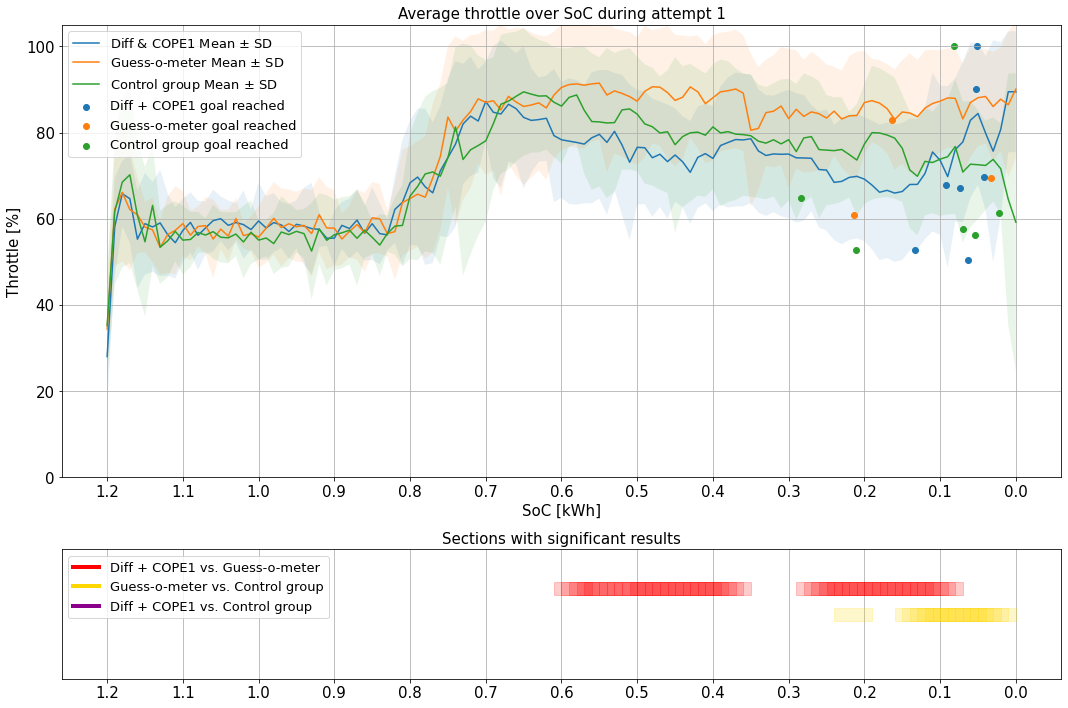

In [170]:
def plotGroupAverage(variable, attempt):
  variable_to_plot = variable
  attempt_nr = attempt

  fig, (ax, ax2) = plt.subplots(2,1,figsize=(15,10),gridspec_kw={'height_ratios': [3.5, 1]})

  # plot mean
  diff_cope_mean = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == attempt_nr)]
  ax.plot(diff_cope_mean["normalizing_window"], diff_cope_mean[variable_to_plot], label="Diff & COPE1 Mean $\pm$ SD")
  
  guess_o_meter_mean = average_groups[(average_groups.evis_id == "guess_o_meter") & (average_groups.attempt == attempt_nr)]
  ax.plot(guess_o_meter_mean["normalizing_window"], guess_o_meter_mean[variable_to_plot], label="Guess-o-meter Mean $\pm$ SD")
  
  control_group_mean = average_groups[(average_groups.evis_id == "control_group") & (average_groups.attempt == attempt_nr)]
  ax.plot(control_group_mean["normalizing_window"], control_group_mean[variable_to_plot], label="Control group Mean $\pm$ SD")
  
  # plot STD
  plt.gca().set_prop_cycle(None) # Restarts the color cycle
  std_alpha = 0.1
  
  diff_group_std = std_groups[(std_groups.evis_id == "diff_and_cope1") & (std_groups.attempt == attempt_nr)]
  ax.fill_between(
    diff_cope_mean["normalizing_window"], 
    diff_cope_mean[variable_to_plot] + diff_group_std[variable_to_plot],
    diff_cope_mean[variable_to_plot] - diff_group_std[variable_to_plot],
    alpha=std_alpha)
  
  guess_o_meter_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "guess_o_meter")]
  ax.fill_between(
    guess_o_meter_mean["normalizing_window"], 
    guess_o_meter_mean[variable_to_plot] + guess_o_meter_std[variable_to_plot],
    guess_o_meter_mean[variable_to_plot] - guess_o_meter_std[variable_to_plot],
    alpha=std_alpha)
  
  control_group_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "control_group")]
  ax.fill_between(
    control_group_mean["normalizing_window"], 
    control_group_mean[variable_to_plot] + control_group_std[variable_to_plot],
    control_group_mean[variable_to_plot] - control_group_std[variable_to_plot],
    alpha=std_alpha)

  ax.set_prop_cycle(None)
  
  diff_cope_goal_reached = average_individual_successful[(average_individual_successful.evis_id == "diff_and_cope1") & (average_individual_successful.attempt == 1)].groupby(["user_id"]).head(1)
  ax.scatter(diff_cope_goal_reached[variable_to_normalize_against], diff_cope_goal_reached[variable_to_plot], label="Diff + COPE1 goal reached")
  
  
  diff_cope_goal_reached = average_individual_successful[(average_individual_successful.evis_id == "guess_o_meter") & (average_individual_successful.attempt == 1)].groupby(["user_id"]).head(1)
  ax.scatter(diff_cope_goal_reached[variable_to_normalize_against], diff_cope_goal_reached[variable_to_plot], label="Guess-o-meter goal reached")
  
  
  diff_cope_goal_reached = average_individual_successful[(average_individual_successful.evis_id == "control_group") & (average_individual_successful.attempt == 1)].groupby(["user_id"]).head(1)
  ax.scatter(diff_cope_goal_reached[variable_to_normalize_against], diff_cope_goal_reached[variable_to_plot], label="Control group goal reached")
  
  
  # Set figure title
  tb1 = variables_print_pretty[variable_to_plot].lower()
  tb2 = str(attempt)
  ax.set_title("Average " + tb1 + " over SoC during attempt " + tb2)
  
  # Set the y-lim based on what variable we are plotting
  if variable_to_plot == "speed":
    ax.set_ylim(0,130)
  if variable_to_plot == "power_usage":
    ax.set_ylim(-10,80)
  if variable_to_plot == "throttle_position":
    ax.set_ylim(0,105)
 
  #road_evel_ax.legend()
  ax.legend(loc="upper left")  
  #ax.legend()  
  ax.grid(True)
  #ax.set_xlabel("Range estimate [km] (rounded down to whole number in EVIS)")
  ax.set_xlabel("SoC [kWh]")
  ax.set_ylabel(variables_print_pretty[variable_to_plot] + " " + variables_unit[variable_to_plot])
  
  ax.xaxis.set_minor_locator(MultipleLocator(100))
  ax.xaxis.grid(True, which='minor')
  
  ax.set_xticks(np.arange(0, 1.21, step=0.1))
  ax.invert_xaxis()


  ### Show significant differences ###
  thicknes = 0.1
  spacing = 0.1
  start_y_base = 0.25
  ax2.set_xlim(-400,8400)
  ax2.get_yaxis().set_visible(False)
  ax2.grid(True)
  padding = 0.06
  ax2.set_xlim(0-padding,1.2+padding)
  ax2.set_xticks(np.arange(0, 1.21, step=0.1))
  ax2.set_title("Sections with significant results")
  ax2.invert_xaxis()
  
  for difference in significant_differences:
    if difference["which"] == "control & diff":
      color = "darkmagenta"
      start_y = start_y_base
    if difference["which"] == "control & guess":
      color = "gold"
      start_y = start_y_base + thicknes + spacing
    if difference["which"] == "diff & guess":
      color = "red"
      start_y = start_y_base + (thicknes + spacing) * 2
    
    start_x = difference["section"][0]
    end_x = difference["section"][1]
    
    end_y = start_y + thicknes
    
    rect = Rectangle((start_x, start_y), 
                 end_x-start_x, end_y-start_y, 
                 fill=True, 
                 zorder=100,
                 alpha=0.2,
                 color=color)
    
    ax2.add_patch(rect)  
  
  custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="gold", lw=4),
                Line2D([0], [0], color="darkmagenta", lw=4)]
  ax2.legend(custom_lines, 
             ['Diff + COPE1 vs. Guess-o-meter', 'Guess-o-meter vs. Control group', 'Diff + COPE1 vs. Control group'],
            loc="upper left")
  ax.legend(loc="upper left")
  
  plt.tight_layout()
  plt.savefig("/home/steve/Pictures/figures/20-4/throttle_over_soc_search.png", dpi=200)  
  plt.show()
  
  
variable = "speed"
#plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "power_usage"
#plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "throttle_position"
plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "current_soc"
#plotGroupAverage(variable, 1)

In [169]:
for x in significant_differences:
  print(x)

{'section': array([0.  , 0.05]), 'which': 'control & guess', 'p-value': 0.013493, 'N control': 7, 'N guess': 11, 'control mean': 70.35, 'guess mean': 83.35}
{'section': array([0.01, 0.06]), 'which': 'control & guess', 'p-value': 0.015589, 'N control': 7, 'N guess': 11, 'control mean': 73.19, 'guess mean': 82.24}
{'section': array([0.02, 0.07]), 'which': 'control & guess', 'p-value': 0.007144, 'N control': 8, 'N guess': 11, 'control mean': 73.62, 'guess mean': 79.81}
{'section': array([0.03, 0.08]), 'which': 'control & guess', 'p-value': 0.030406, 'N control': 8, 'N guess': 12, 'control mean': 74.93, 'guess mean': 79.0}
{'section': array([0.04, 0.09]), 'which': 'control & guess', 'p-value': 0.040104, 'N control': 8, 'N guess': 12, 'control mean': 75.87, 'guess mean': 77.44}
{'section': array([0.05, 0.1 ]), 'which': 'control & guess', 'p-value': 0.027369, 'N control': 9, 'N guess': 12, 'control mean': 74.15, 'guess mean': 80.77}
{'section': array([0.06, 0.11]), 'which': 'control & guess'

### Significance for specific sections

In [208]:
sections = [
  #[0.05, 0.7],
  [0.05, 0.9],
  [0.1, 0.9]
]

In [209]:
def ttest_independent(samp_1, samp_2):
    # Check if equal variances
    s,p = stats.levene(samp_1, samp_2)
    equal_var = True
    if p < 0.05:
      equal_var = False
    
    s,p = stats.ttest_ind(samp_1, samp_2, equal_var=equal_var)
    
    return {
      "p": round(p,6),
      "N1": samp_1.count(),
      "N2": samp_2.count(),
      "samp1_mean": round(samp_1.mean(), 2),
      "samp2_mean": round(samp_2.mean(), 2)
    }
    
variable = "throttle_position" 
which_attempt = 1

significant_differences = []

section = section_size.copy()
for section in sections:
    print(section)
    evis = "diff_and_cope1"
    individual = average_individual[(average_individual.attempt == which_attempt) & (average_individual.evis_id == evis)] # Get one particular attempt and evis values
    a1_mean_speeds_diff = individual.pivot(index="normalizing_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user

    evis = "guess_o_meter"
    individual = average_individual[(average_individual.attempt == which_attempt) & (average_individual.evis_id == evis)] # Get one particular attempt and evis values
    a1_mean_speeds_guess = individual.pivot(index="normalizing_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user

    evis = "control_group"
    individual = average_individual[(average_individual.attempt == which_attempt) & (average_individual.evis_id == evis)] # Get one particular attempt and evis values
    a1_mean_speeds_control = individual.pivot(index="normalizing_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user
  
    # Remove users who do not have data for the entire range and then calculate mean
    a1_mean_speeds_diff_section = a1_mean_speeds_diff.loc[section[0]:section[1]].dropna(axis=1).mean()
    a1_mean_speeds_guess_section = a1_mean_speeds_guess.loc[section[0]:section[1]].dropna(axis=1).mean()
    a1_mean_speeds_control_section = a1_mean_speeds_control.loc[section[0]:section[1]].dropna(axis=1).mean()
    
    t_test_control_guess = ttest_independent(a1_mean_speeds_control_section, a1_mean_speeds_guess_section)
    t_test_control_diff = ttest_independent(a1_mean_speeds_control_section, a1_mean_speeds_diff_section)
    t_test_diff_guess = ttest_independent(a1_mean_speeds_diff_section, a1_mean_speeds_guess_section)
    
    any_one_found = False
    if (t_test_control_diff["p"] < 0.05 or t_test_control_guess["p"] < 0.05 or  t_test_diff_guess["p"] < 0.05):
      any_one_found = True
    
    if any_one_found:
      if t_test_control_diff["p"] < 0.05:
        print("\t Found")
        significant_differences.append({
          "section":section.copy(), 
          "which":"control & diff", 
          "p-value": t_test_control_diff["p"], 
          "N Control": t_test_control_diff["N1"], 
          "N diff + COPE1": t_test_control_diff["N2"],
          "control mean": t_test_control_diff["samp1_mean"],
          "diff mean": t_test_control_diff["samp2_mean"]
        })
      
    if any_one_found:
      if t_test_control_guess["p"] < 0.05:
        print("\t Found")
        significant_differences.append({
          "section":section.copy(), 
          "which":"control & guess", 
          "p-value": t_test_control_guess["p"],
          "N control": t_test_control_guess["N1"],
          "N guess": t_test_control_guess["N2"],
          "control mean": t_test_control_diff["samp1_mean"],
          "guess mean": t_test_control_diff["samp2_mean"]
        })
    
    if any_one_found:
      if t_test_diff_guess["p"] < 0.05:
        print("\t Found")
        significant_differences.append({
          "section":section.copy(), 
          "which":"diff & guess", 
          "p-value": t_test_diff_guess["p"],
          "N diff + COPE1": t_test_diff_guess["N1"],
          "N guess": t_test_diff_guess["N2"],
          "diff mean": t_test_control_diff["samp1_mean"],
          "guess mean": t_test_control_diff["samp2_mean"]
        })

[0.05, 0.9]
	 Found
[0.1, 0.9]
	 Found
	 Found


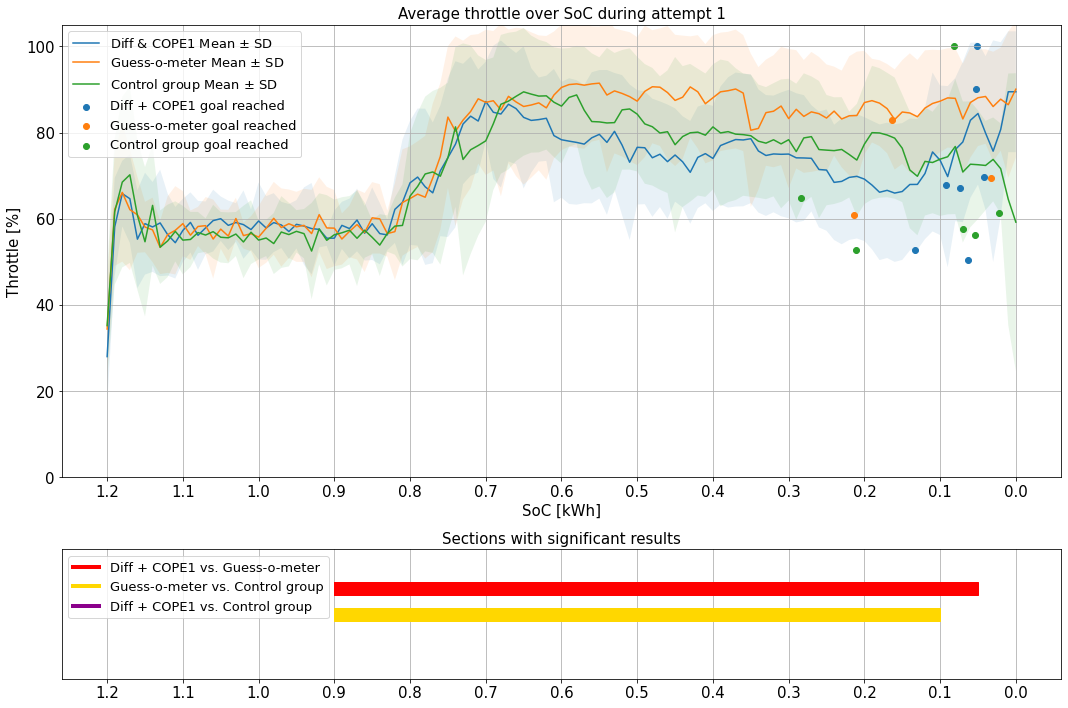

In [212]:
def plotGroupAverage(variable, attempt):
  variable_to_plot = variable
  attempt_nr = attempt

  fig, (ax, ax2) = plt.subplots(2,1,figsize=(15,10),gridspec_kw={'height_ratios': [3.5, 1]})

  # plot mean
  diff_cope_mean = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == attempt_nr)]
  ax.plot(diff_cope_mean["normalizing_window"], diff_cope_mean[variable_to_plot], label="Diff & COPE1 Mean $\pm$ SD")
  
  guess_o_meter_mean = average_groups[(average_groups.evis_id == "guess_o_meter") & (average_groups.attempt == attempt_nr)]
  ax.plot(guess_o_meter_mean["normalizing_window"], guess_o_meter_mean[variable_to_plot], label="Guess-o-meter Mean $\pm$ SD")
  
  control_group_mean = average_groups[(average_groups.evis_id == "control_group") & (average_groups.attempt == attempt_nr)]
  ax.plot(control_group_mean["normalizing_window"], control_group_mean[variable_to_plot], label="Control group Mean $\pm$ SD")
  
  # plot STD
  plt.gca().set_prop_cycle(None) # Restarts the color cycle
  std_alpha = 0.1
  
  diff_group_std = std_groups[(std_groups.evis_id == "diff_and_cope1") & (std_groups.attempt == attempt_nr)]
  ax.fill_between(
    diff_cope_mean["normalizing_window"], 
    diff_cope_mean[variable_to_plot] + diff_group_std[variable_to_plot],
    diff_cope_mean[variable_to_plot] - diff_group_std[variable_to_plot],
    alpha=std_alpha)
  
  guess_o_meter_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "guess_o_meter")]
  ax.fill_between(
    guess_o_meter_mean["normalizing_window"], 
    guess_o_meter_mean[variable_to_plot] + guess_o_meter_std[variable_to_plot],
    guess_o_meter_mean[variable_to_plot] - guess_o_meter_std[variable_to_plot],
    alpha=std_alpha)
  
  control_group_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "control_group")]
  ax.fill_between(
    control_group_mean["normalizing_window"], 
    control_group_mean[variable_to_plot] + control_group_std[variable_to_plot],
    control_group_mean[variable_to_plot] - control_group_std[variable_to_plot],
    alpha=std_alpha)

  ax.set_prop_cycle(None)
  
  diff_cope_goal_reached = average_individual_successful[(average_individual_successful.evis_id == "diff_and_cope1") & (average_individual_successful.attempt == 1)].groupby(["user_id"]).head(1)
  ax.scatter(diff_cope_goal_reached[variable_to_normalize_against], diff_cope_goal_reached[variable_to_plot], label="Diff + COPE1 goal reached")
  
  
  diff_cope_goal_reached = average_individual_successful[(average_individual_successful.evis_id == "guess_o_meter") & (average_individual_successful.attempt == 1)].groupby(["user_id"]).head(1)
  ax.scatter(diff_cope_goal_reached[variable_to_normalize_against], diff_cope_goal_reached[variable_to_plot], label="Guess-o-meter goal reached")
  
  
  diff_cope_goal_reached = average_individual_successful[(average_individual_successful.evis_id == "control_group") & (average_individual_successful.attempt == 1)].groupby(["user_id"]).head(1)
  ax.scatter(diff_cope_goal_reached[variable_to_normalize_against], diff_cope_goal_reached[variable_to_plot], label="Control group goal reached")
  
  # Set figure title
  tb1 = variables_print_pretty[variable_to_plot].lower()
  tb2 = str(attempt)
  ax.set_title("Average " + tb1 + " over SoC during attempt " + tb2)
  
  # Set the y-lim based on what variable we are plotting
  if variable_to_plot == "speed":
    ax.set_ylim(0,130)
  if variable_to_plot == "power_usage":
    ax.set_ylim(-10,80)
  if variable_to_plot == "throttle_position":
    ax.set_ylim(0,105)
 
  #road_evel_ax.legend()
  ax.legend(loc="upper left")  
  #ax.legend()  
  ax.grid(True)
  #ax.set_xlabel("Range estimate [km] (rounded down to whole number in EVIS)")
  ax.set_xlabel("SoC [kWh]")
  ax.set_ylabel(variables_print_pretty[variable_to_plot] + " " + variables_unit[variable_to_plot])
  
  ax.xaxis.set_minor_locator(MultipleLocator(100))
  ax.xaxis.grid(True, which='minor')
  
  ax.set_xticks(np.arange(0, 1.21, step=0.1))
  ax.invert_xaxis()


  ### Show significant differences ###
  thicknes = 0.1
  spacing = 0.1
  start_y_base = 0.25
  ax2.set_xlim(-400,8400)
  ax2.get_yaxis().set_visible(False)
  ax2.grid(True)
  padding = 0.06
  ax2.set_xlim(0-padding,1.2+padding)
  ax2.set_xticks(np.arange(0, 1.21, step=0.1))
  ax2.set_title("Sections with significant results")
  ax2.invert_xaxis()
  
  for difference in significant_differences:
    if difference["which"] == "control & diff":
      color = "darkmagenta"
      start_y = start_y_base
    if difference["which"] == "control & guess":
      color = "gold"
      start_y = start_y_base + thicknes + spacing
    if difference["which"] == "diff & guess":
      color = "red"
      start_y = start_y_base + (thicknes + spacing) * 2
    
    start_x = difference["section"][0]
    end_x = difference["section"][1]
    
    end_y = start_y + thicknes
    
    rect = Rectangle((start_x, start_y), 
                 end_x-start_x, end_y-start_y, 
                 fill=True, 
                 zorder=100,
                 alpha=1.0,
                 color=color)
    
    ax2.add_patch(rect)  
  
  custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="gold", lw=4),
                Line2D([0], [0], color="darkmagenta", lw=4)]
  ax2.legend(custom_lines, 
             ['Diff + COPE1 vs. Guess-o-meter', 'Guess-o-meter vs. Control group', 'Diff + COPE1 vs. Control group'],
            loc="upper left")
  ax.legend(loc="upper left")
  
  plt.tight_layout()
  #plt.savefig("/home/steve/Pictures/figures/20-4/throttle_over_soc_specific_sections.png", dpi=200)  
  plt.show()
  
  
variable = "speed"
#plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "power_usage"
#plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "throttle_position"
plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "current_soc"
#plotGroupAverage(variable, 1)

In [211]:
for x in significant_differences:
  print(x)

{'section': [0.05, 0.9], 'which': 'diff & guess', 'p-value': 0.003005, 'N diff + COPE1': 9, 'N guess': 12, 'diff mean': 78.86, 'guess mean': 74.62}
{'section': [0.1, 0.9], 'which': 'control & guess', 'p-value': 0.027957, 'N control': 11, 'N guess': 12, 'control mean': 78.52, 'guess mean': 73.75}
{'section': [0.1, 0.9], 'which': 'diff & guess', 'p-value': 0.000452, 'N diff + COPE1': 12, 'N guess': 12, 'diff mean': 78.52, 'guess mean': 73.75}


In [116]:
for x in significant_differences:
  print(x)

{'section': array([0.  , 0.05]), 'which': 'control & guess', 'p-value': 0.042134, 'N control': 7, 'N guess': 11, 'control mean': 66.36, 'guess mean': 70.53}
{'section': array([0.02, 0.07]), 'which': 'control & guess', 'p-value': 0.03657, 'N control': 8, 'N guess': 11, 'control mean': 68.3, 'guess mean': 68.21}
{'section': array([0.06, 0.11]), 'which': 'control & guess', 'p-value': 0.032245, 'N control': 10, 'N guess': 12, 'control mean': 65.35, 'guess mean': 63.55}
{'section': array([0.06, 0.11]), 'which': 'diff & guess', 'p-value': 0.029208, 'N diff + COPE1': 11, 'N guess': 12, 'diff mean': 65.35, 'guess mean': 63.55}
{'section': array([0.07, 0.12]), 'which': 'control & guess', 'p-value': 0.033558, 'N control': 10, 'N guess': 12, 'control mean': 65.26, 'guess mean': 63.09}
{'section': array([0.07, 0.12]), 'which': 'diff & guess', 'p-value': 0.026912, 'N diff + COPE1': 11, 'N guess': 12, 'diff mean': 65.26, 'guess mean': 63.09}
{'section': array([0.08, 0.13]), 'which': 'control & guess

### Significance for specific sections

In [202]:
sections = [
  [0.0, 0.8],
  [0.1, 0.9]
]

In [203]:
def ttest_independent(samp_1, samp_2):
    # Check if equal variances
    s,p = stats.levene(samp_1, samp_2)
    equal_var = True
    if p < 0.05:
      equal_var = False
    
    s,p = stats.ttest_ind(samp_1, samp_2, equal_var=equal_var)
    
    return {
      "p": round(p,6),
      "N1": samp_1.count(),
      "N2": samp_2.count(),
      "samp1_mean": round(samp_1.mean(), 2),
      "samp2_mean": round(samp_2.mean(), 2)
    }
    
variable = "throttle_position" 
which_attempt = 1

significant_differences = []

section = section_size.copy()
for section in sections:
    print(section)
    evis = "diff_and_cope1"
    individual = average_individual[(average_individual.attempt == which_attempt) & (average_individual.evis_id == evis)] # Get one particular attempt and evis values
    a1_mean_speeds_diff = individual.pivot(index="normalizing_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user

    evis = "guess_o_meter"
    individual = average_individual[(average_individual.attempt == which_attempt) & (average_individual.evis_id == evis)] # Get one particular attempt and evis values
    a1_mean_speeds_guess = individual.pivot(index="normalizing_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user

    evis = "control_group"
    individual = average_individual[(average_individual.attempt == which_attempt) & (average_individual.evis_id == evis)] # Get one particular attempt and evis values
    a1_mean_speeds_control = individual.pivot(index="normalizing_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user
  
    # Remove users who do not have data for the entire range and then calculate mean
    a1_mean_speeds_diff_section = a1_mean_speeds_diff.loc[section[0]:section[1]].dropna(axis=1).mean()
    a1_mean_speeds_guess_section = a1_mean_speeds_guess.loc[section[0]:section[1]].dropna(axis=1).mean()
    a1_mean_speeds_control_section = a1_mean_speeds_control.loc[section[0]:section[1]].dropna(axis=1).mean()
    
    t_test_control_guess = ttest_independent(a1_mean_speeds_control_section, a1_mean_speeds_guess_section)
    t_test_control_diff = ttest_independent(a1_mean_speeds_control_section, a1_mean_speeds_diff_section)
    t_test_diff_guess = ttest_independent(a1_mean_speeds_diff_section, a1_mean_speeds_guess_section)
    
    any_one_found = False
    if (t_test_control_diff["p"] < 0.05 or t_test_control_guess["p"] < 0.05 or  t_test_diff_guess["p"] < 0.05):
      any_one_found = True
    
    if any_one_found:
      if t_test_control_diff["p"] < 0.05:
        print("\t Found")
        significant_differences.append({
          "section":section.copy(), 
          "which":"control & diff", 
          "p-value": t_test_control_diff["p"], 
          "N Control": t_test_control_diff["N1"], 
          "N diff + COPE1": t_test_control_diff["N2"],
          "control mean": t_test_control_diff["samp1_mean"],
          "diff mean": t_test_control_diff["samp2_mean"]
        })
      
    if any_one_found:
      if t_test_control_guess["p"] < 0.05:
        print("\t Found")
        significant_differences.append({
          "section":section.copy(), 
          "which":"control & guess", 
          "p-value": t_test_control_guess["p"],
          "N control": t_test_control_guess["N1"],
          "N guess": t_test_control_guess["N2"],
          "control mean": t_test_control_diff["samp1_mean"],
          "guess mean": t_test_control_diff["samp2_mean"]
        })
    
    if any_one_found:
      if t_test_diff_guess["p"] < 0.05:
        print("\t Found")
        significant_differences.append({
          "section":section.copy(), 
          "which":"diff & guess", 
          "p-value": t_test_diff_guess["p"],
          "N diff + COPE1": t_test_diff_guess["N1"],
          "N guess": t_test_diff_guess["N2"],
          "diff mean": t_test_control_diff["samp1_mean"],
          "guess mean": t_test_control_diff["samp2_mean"]
        })

[0.0, 0.8]
	 Found
[0.1, 0.9]
	 Found
	 Found


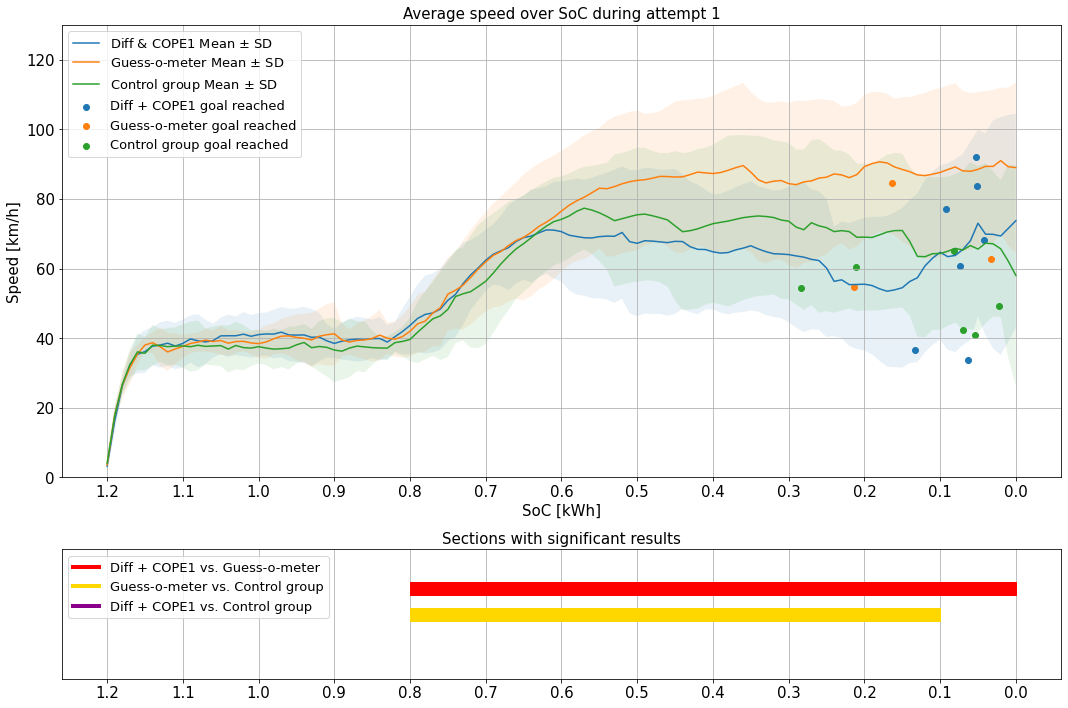

In [165]:
def plotGroupAverage(variable, attempt):
  variable_to_plot = variable
  attempt_nr = attempt

  fig, (ax, ax2) = plt.subplots(2,1,figsize=(15,10),gridspec_kw={'height_ratios': [3.5, 1]})

  # plot mean
  diff_cope_mean = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == attempt_nr)]
  ax.plot(diff_cope_mean["normalizing_window"], diff_cope_mean[variable_to_plot], label="Diff & COPE1 Mean $\pm$ SD")
  
  guess_o_meter_mean = average_groups[(average_groups.evis_id == "guess_o_meter") & (average_groups.attempt == attempt_nr)]
  ax.plot(guess_o_meter_mean["normalizing_window"], guess_o_meter_mean[variable_to_plot], label="Guess-o-meter Mean $\pm$ SD")
  
  control_group_mean = average_groups[(average_groups.evis_id == "control_group") & (average_groups.attempt == attempt_nr)]
  ax.plot(control_group_mean["normalizing_window"], control_group_mean[variable_to_plot], label="Control group Mean $\pm$ SD")
  
  # plot STD
  plt.gca().set_prop_cycle(None) # Restarts the color cycle
  std_alpha = 0.1
  
  diff_group_std = std_groups[(std_groups.evis_id == "diff_and_cope1") & (std_groups.attempt == attempt_nr)]
  ax.fill_between(
    diff_cope_mean["normalizing_window"], 
    diff_cope_mean[variable_to_plot] + diff_group_std[variable_to_plot],
    diff_cope_mean[variable_to_plot] - diff_group_std[variable_to_plot],
    alpha=std_alpha)
  
  guess_o_meter_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "guess_o_meter")]
  ax.fill_between(
    guess_o_meter_mean["normalizing_window"], 
    guess_o_meter_mean[variable_to_plot] + guess_o_meter_std[variable_to_plot],
    guess_o_meter_mean[variable_to_plot] - guess_o_meter_std[variable_to_plot],
    alpha=std_alpha)
  
  control_group_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "control_group")]
  ax.fill_between(
    control_group_mean["normalizing_window"], 
    control_group_mean[variable_to_plot] + control_group_std[variable_to_plot],
    control_group_mean[variable_to_plot] - control_group_std[variable_to_plot],
    alpha=std_alpha)

  ax.set_prop_cycle(None)
  
  diff_cope_goal_reached = average_individual_successful[(average_individual_successful.evis_id == "diff_and_cope1") & (average_individual_successful.attempt == 1)].groupby(["user_id"]).head(1)
  ax.scatter(diff_cope_goal_reached[variable_to_normalize_against], diff_cope_goal_reached[variable_to_plot], label="Diff + COPE1 goal reached")
  
  
  diff_cope_goal_reached = average_individual_successful[(average_individual_successful.evis_id == "guess_o_meter") & (average_individual_successful.attempt == 1)].groupby(["user_id"]).head(1)
  ax.scatter(diff_cope_goal_reached[variable_to_normalize_against], diff_cope_goal_reached[variable_to_plot], label="Guess-o-meter goal reached")
  
  
  diff_cope_goal_reached = average_individual_successful[(average_individual_successful.evis_id == "control_group") & (average_individual_successful.attempt == 1)].groupby(["user_id"]).head(1)
  ax.scatter(diff_cope_goal_reached[variable_to_normalize_against], diff_cope_goal_reached[variable_to_plot], label="Control group goal reached")
  
  # Set figure title
  tb1 = variables_print_pretty[variable_to_plot].lower()
  tb2 = str(attempt)
  ax.set_title("Average " + tb1 + " over SoC during attempt " + tb2)
  
  # Set the y-lim based on what variable we are plotting
  if variable_to_plot == "speed":
    ax.set_ylim(0,130)
  if variable_to_plot == "power_usage":
    ax.set_ylim(-10,80)
  if variable_to_plot == "throttle_position":
    ax.set_ylim(0,105)
 
  #road_evel_ax.legend()
  ax.legend(loc="upper left")  
  #ax.legend()  
  ax.grid(True)
  #ax.set_xlabel("Range estimate [km] (rounded down to whole number in EVIS)")
  ax.set_xlabel("SoC [kWh]")
  ax.set_ylabel(variables_print_pretty[variable_to_plot] + " " + variables_unit[variable_to_plot])
  
  ax.xaxis.set_minor_locator(MultipleLocator(100))
  ax.xaxis.grid(True, which='minor')
  
  ax.set_xticks(np.arange(0, 1.21, step=0.1))
  ax.invert_xaxis()


  ### Show significant differences ###
  thicknes = 0.1
  spacing = 0.1
  start_y_base = 0.25
  ax2.set_xlim(-400,8400)
  ax2.get_yaxis().set_visible(False)
  ax2.grid(True)
  padding = 0.06
  ax2.set_xlim(0-padding,1.2+padding)
  ax2.set_xticks(np.arange(0, 1.21, step=0.1))
  ax2.set_title("Sections with significant results")
  ax2.invert_xaxis()
  
  for difference in significant_differences:
    if difference["which"] == "control & diff":
      color = "darkmagenta"
      start_y = start_y_base
    if difference["which"] == "control & guess":
      color = "gold"
      start_y = start_y_base + thicknes + spacing
    if difference["which"] == "diff & guess":
      color = "red"
      start_y = start_y_base + (thicknes + spacing) * 2
    
    start_x = difference["section"][0]
    end_x = difference["section"][1]
    
    end_y = start_y + thicknes
    
    rect = Rectangle((start_x, start_y), 
                 end_x-start_x, end_y-start_y, 
                 fill=True, 
                 zorder=100,
                 alpha=1.0,
                 color=color)
    
    ax2.add_patch(rect)  
  
  custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="gold", lw=4),
                Line2D([0], [0], color="darkmagenta", lw=4)]
  ax2.legend(custom_lines, 
             ['Diff + COPE1 vs. Guess-o-meter', 'Guess-o-meter vs. Control group', 'Diff + COPE1 vs. Control group'],
            loc="upper left")
  ax.legend(loc="upper left")
  
  plt.tight_layout()
  #plt.savefig("/home/steve/Pictures/figures/20-4/speed_over_soc_specific_sections.png", dpi=200)  
  plt.show()
  
  
variable = "speed"
#plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "power_usage"
#plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "throttle_position"
plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "current_soc"
#plotGroupAverage(variable, 1)

In [164]:
for x in significant_differences:
  print(x)

{'section': [0.0, 0.8], 'which': 'diff & guess', 'p-value': 0.021908, 'N diff + COPE1': 6, 'N guess': 11, 'diff mean': 75.46, 'guess mean': 67.13}
{'section': [0.1, 0.8], 'which': 'control & guess', 'p-value': 0.026901, 'N control': 11, 'N guess': 12, 'control mean': 70.65, 'guess mean': 63.12}
{'section': [0.1, 0.8], 'which': 'diff & guess', 'p-value': 0.000332, 'N diff + COPE1': 12, 'N guess': 12, 'diff mean': 70.65, 'guess mean': 63.12}


## Plot successful attempts

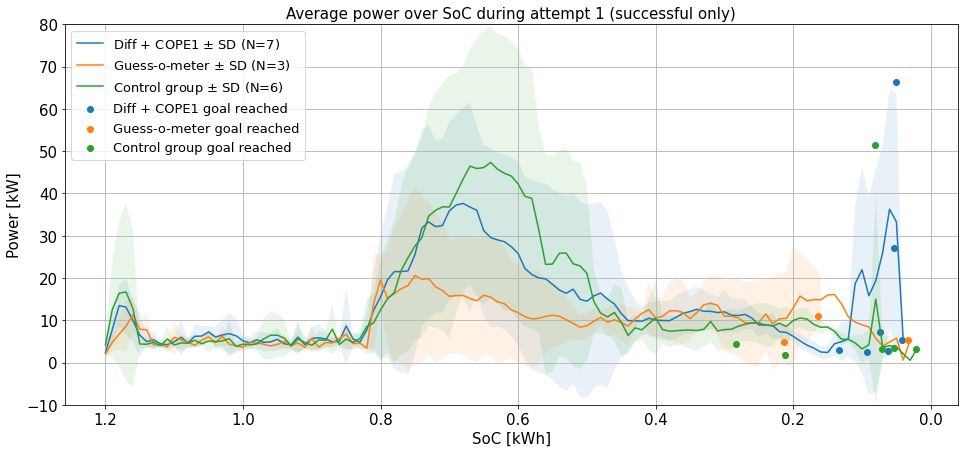

In [144]:
def plotGroupAverage(variable, attempt):
  variable_to_plot = variable
  attempt_nr = attempt

  fig, ax = plt.subplots(figsize=(16,7))

  plus_minus = r'$\pm$'
  
  # plot mean
  diff_cope_mean_s = average_groups_successful[(average_groups_successful.evis_id == "diff_and_cope1") & (average_groups_successful.attempt == attempt_nr)]
  individual_count = len(average_individual_successful[(average_individual_successful.evis_id == "diff_and_cope1") & (average_individual_successful.attempt == attempt_nr)].user_id.unique())
  label = "Diff + COPE1 $\pm$ SD (N=" + str(individual_count) + ")"
  plt.plot(diff_cope_mean_s["normalizing_window"], diff_cope_mean_s[variable_to_plot], label=label)

  guess_o_meter_mean_s = average_groups_successful[(average_groups_successful.evis_id == "guess_o_meter") & (average_groups_successful.attempt == attempt_nr)]
  individual_count = len(average_individual_successful[(average_individual_successful.evis_id == "guess_o_meter") & (average_individual_successful.attempt == attempt_nr)].user_id.unique())
  label = "Guess-o-meter $\pm$ SD (N=" + str(individual_count) + ")"
  plt.plot(guess_o_meter_mean_s["normalizing_window"], guess_o_meter_mean_s[variable_to_plot], label=label)

  control_group_mean_s = average_groups_successful[(average_groups_successful.evis_id == "control_group") & (average_groups_successful.attempt == attempt_nr)]
  individual_count = len(average_individual_successful[(average_individual_successful.evis_id == "control_group") & (average_individual_successful.attempt == attempt_nr)].user_id.unique())
  label = "Control group $\pm$ SD (N=" + str(individual_count) + ")"
  plt.plot(control_group_mean_s["normalizing_window"], control_group_mean_s[variable_to_plot], label=label)
   
  # plot STD
  plt.gca().set_prop_cycle(None) # Restarts the color cycle
  std_alpha = 0.1

  diff_group_std_s = std_groups_successful[(std_groups_successful.attempt == attempt_nr) & (std_groups_successful.evis_id == "diff_and_cope1")].fillna(0)
  plt.fill_between(
    diff_cope_mean_s["normalizing_window"], 
    diff_cope_mean_s[variable_to_plot] + diff_group_std_s[variable_to_plot],
    diff_cope_mean_s[variable_to_plot] - diff_group_std_s[variable_to_plot],
    alpha=std_alpha)

  guess_o_meter_std_s = std_groups_successful[(std_groups_successful.attempt == attempt_nr) & (std_groups_successful.evis_id == "guess_o_meter")]
  plt.fill_between(
    guess_o_meter_mean_s["normalizing_window"], 
    guess_o_meter_mean_s[variable_to_plot] + guess_o_meter_std_s[variable_to_plot],
    guess_o_meter_mean_s[variable_to_plot] - guess_o_meter_std_s[variable_to_plot],
    alpha=std_alpha)

  control_group_std_s = std_groups_successful[(std_groups_successful.attempt == attempt_nr) & (std_groups_successful.evis_id == "control_group")]
  plt.fill_between(
    control_group_mean_s["normalizing_window"], 
    control_group_mean_s[variable_to_plot] + control_group_std_s[variable_to_plot],
    control_group_mean_s[variable_to_plot] - control_group_std_s[variable_to_plot],
    alpha=std_alpha)

  # plot fails
  plt.gca().set_prop_cycle(None)
  
  diff_cope_goal_reached = average_individual_successful[(average_individual_successful.evis_id == "diff_and_cope1") & (average_individual_successful.attempt == 1)].groupby(["user_id"]).head(1)
  plt.scatter(diff_cope_goal_reached[variable_to_normalize_against], diff_cope_goal_reached[variable_to_plot], label="Diff + COPE1 goal reached")
  
  
  diff_cope_goal_reached = average_individual_successful[(average_individual_successful.evis_id == "guess_o_meter") & (average_individual_successful.attempt == 1)].groupby(["user_id"]).head(1)
  plt.scatter(diff_cope_goal_reached[variable_to_normalize_against], diff_cope_goal_reached[variable_to_plot], label="Guess-o-meter goal reached")
  
  
  diff_cope_goal_reached = average_individual_successful[(average_individual_successful.evis_id == "control_group") & (average_individual_successful.attempt == 1)].groupby(["user_id"]).head(1)
  plt.scatter(diff_cope_goal_reached[variable_to_normalize_against], diff_cope_goal_reached[variable_to_plot], label="Control group goal reached")
  
  ax.set_title("Average " + variables_print_pretty[variable_to_plot].lower() + " over SoC during attempt " + str(attempt) + " (successful only)")
  
  # Set the y-lim based on what variable we are plotting
  if variable_to_plot == "speed":
    ax.set_ylim(0,130)
  if variable_to_plot == "power_usage":
    ax.set_ylim(-10,80)
  if variable_to_plot == "throttle_position":
    ax.set_ylim(0,105)
 
  #road_evel_ax.legend()
  ax.legend(loc="upper left")  
  #ax.legend()  
  ax.grid(True)
  #ax.set_xlabel("Range estimate [km] (rounded down to whole number in EVIS)")
  ax.set_xlabel("SoC [kWh]")
  ax.set_ylabel(variables_print_pretty[variable_to_plot] + " " + variables_unit[variable_to_plot])
  
  ax.xaxis.set_minor_locator(MultipleLocator(100))
  ax.xaxis.grid(True, which='minor')
  
  #ax.set_xticks(np.arange(0,11,1))
  if variable_to_normalize_against == "current_soc":
    ax.invert_xaxis()

  title = "average_" + variables_print_pretty[variable_to_plot].lower() + "_over_SoC_attempt_" + str(attempt) + " (successful attempts)"
  #plt.savefig("/home/steve/Pictures/figures/31-3/" + title + ".png", dpi=200)

  plt.show()
  
  
variable = "speed"
#plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "power_usage"
plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "throttle_position"
#plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "current_soc"
#plotGroupAverage(variable, 1)

## Guess o meter SD abruptly stops when there's only one single data point!!!!!

## Plot failed attempts

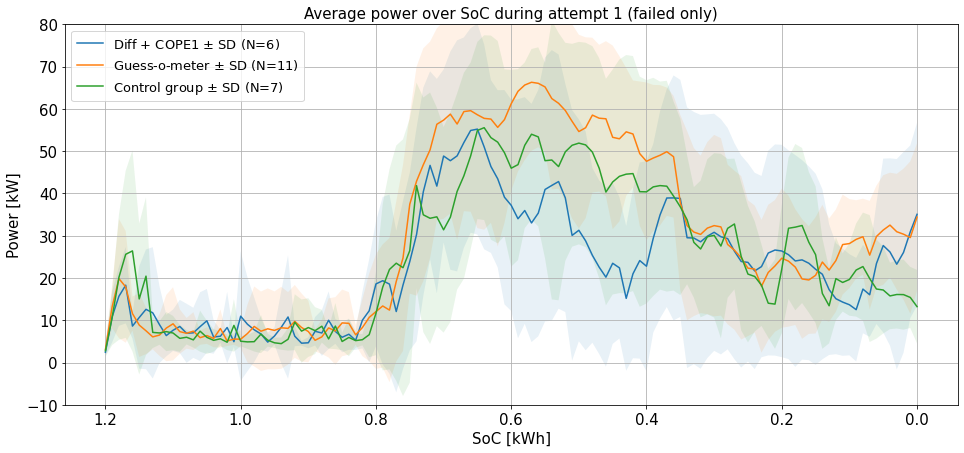

In [146]:
def plotGroupAverage(variable, attempt):
  variable_to_plot = variable
  attempt_nr = attempt

  fig, ax = plt.subplots(figsize=(16,7))

  plus_minus = r'$\pm$'
  
  # plot mean
  diff_cope_mean_f = average_groups_failed[(average_groups_failed.evis_id == "diff_and_cope1") & (average_groups_failed.attempt == attempt_nr)]
  individual_count = len(average_individual_failed[(average_individual_failed.evis_id == "diff_and_cope1") & (average_individual_failed.attempt == attempt_nr)].user_id.unique())
  label = "Diff + COPE1 " + plus_minus + " SD (N=" + str(individual_count) + ")"
  plt.plot(diff_cope_mean_f["normalizing_window"], diff_cope_mean_f[variable_to_plot], label=label)

  guess_o_meter_mean_f = average_groups_failed[(average_groups_failed.evis_id == "guess_o_meter") & (average_groups_failed.attempt == attempt_nr)]
  individual_count = len(average_individual_failed[(average_individual_failed.evis_id == "guess_o_meter") & (average_individual_failed.attempt == attempt_nr)].user_id.unique())
  label = "Guess-o-meter "+plus_minus+" SD (N=" + str(individual_count) + ")"
  plt.plot(guess_o_meter_mean_f["normalizing_window"], guess_o_meter_mean_f[variable_to_plot], label=label)

  control_group_mean_f = average_groups_failed[(average_groups_failed.evis_id == "control_group") & (average_groups_failed.attempt == attempt_nr)]
  individual_count = len(average_individual_failed[(average_individual_failed.evis_id == "control_group") & (average_individual_failed.attempt == attempt_nr)].user_id.unique())
  label = "Control group "+plus_minus+" SD (N=" + str(individual_count) + ")"
  plt.plot(control_group_mean_f["normalizing_window"], control_group_mean_f[variable_to_plot], label=label)
  
  # plot STD
  plt.gca().set_prop_cycle(None) # Restarts the color cycle
  std_alpha = 0.1
  
  diff_group_std_f = std_groups_failed[(std_groups_failed.attempt == attempt_nr) & (std_groups_failed.evis_id == "diff_and_cope1")]
  plt.fill_between(
    diff_cope_mean_f["normalizing_window"], 
    diff_cope_mean_f[variable_to_plot] + diff_group_std_f[variable_to_plot],
    diff_cope_mean_f[variable_to_plot] - diff_group_std_f[variable_to_plot],
    alpha=std_alpha)
  
  guess_o_meter_std_f = std_groups_failed[(std_groups_failed.attempt == attempt_nr) & (std_groups_failed.evis_id == "guess_o_meter")]
  plt.fill_between(
    guess_o_meter_mean_f["normalizing_window"], 
    guess_o_meter_mean_f[variable_to_plot] + guess_o_meter_std_f[variable_to_plot],
    guess_o_meter_mean_f[variable_to_plot] - guess_o_meter_std_f[variable_to_plot],
    alpha=std_alpha)
  
  control_group_std_f = std_groups_failed[(std_groups_failed.attempt == attempt_nr) & (std_groups_failed.evis_id == "control_group")]
  plt.fill_between(
    control_group_mean_f["normalizing_window"], 
    control_group_mean_f[variable_to_plot] + control_group_std_f[variable_to_plot],
    control_group_mean_f[variable_to_plot] - control_group_std_f[variable_to_plot],
    alpha=std_alpha)

  # plot fails
  plt.gca().set_prop_cycle(None)
  
  ax.set_title("Average " + variables_print_pretty[variable_to_plot].lower() + " over SoC during attempt " + str(attempt) + " (failed only)")
  
  # Set the y-lim based on what variable we are plotting
  if variable_to_plot == "speed":
    ax.set_ylim(0,130)
  if variable_to_plot == "power_usage":
    ax.set_ylim(-10,80)
  if variable_to_plot == "throttle_position":
    ax.set_ylim(0,105)
 
  #road_evel_ax.legend()
  ax.legend(loc="upper left")  
  #ax.legend()  
  ax.grid(True)
  #ax.set_xlabel("Range estimate [km] (rounded down to whole number in EVIS)")
  ax.set_xlabel("SoC [kWh]")
  ax.set_ylabel(variables_print_pretty[variable_to_plot] + " " + variables_unit[variable_to_plot])
  
  ax.xaxis.set_minor_locator(MultipleLocator(100))
  ax.xaxis.grid(True, which='minor')
  
  #ax.set_xticks(np.arange(0,11,1))
  ax.invert_xaxis()

  if False:
    title = "average_" + variables_print_pretty[variable_to_plot].lower() + "_over_SoC_attempt_" + str(attempt) + " (failed attempts)"
    #plt.savefig("/home/steve/Pictures/figures/only successful attempts/" + title + ".png", dpi=200)
    #title = "sample_distance_"+str(distance_window_size)+"m"
    plt.savefig("/home/steve/Pictures/figures/31-3/" + title + ".png", dpi=200)

  plt.show()
  
  
variable = "speed"
#plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "power_usage"
plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "throttle_position"
#plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "current_soc"
#plotGroupAverage(variable, 1)

## Guess o meter SD abruptly stops when there's only one single data point!!!!!

## Plot failed and successful together

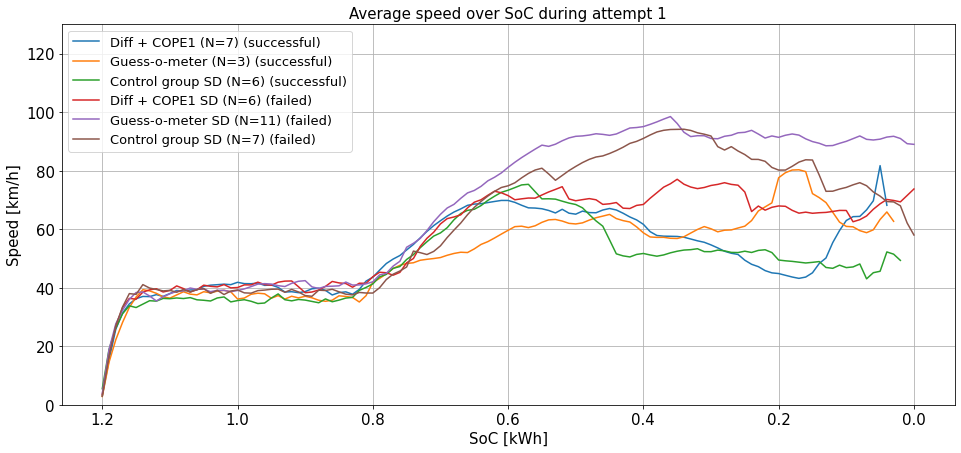

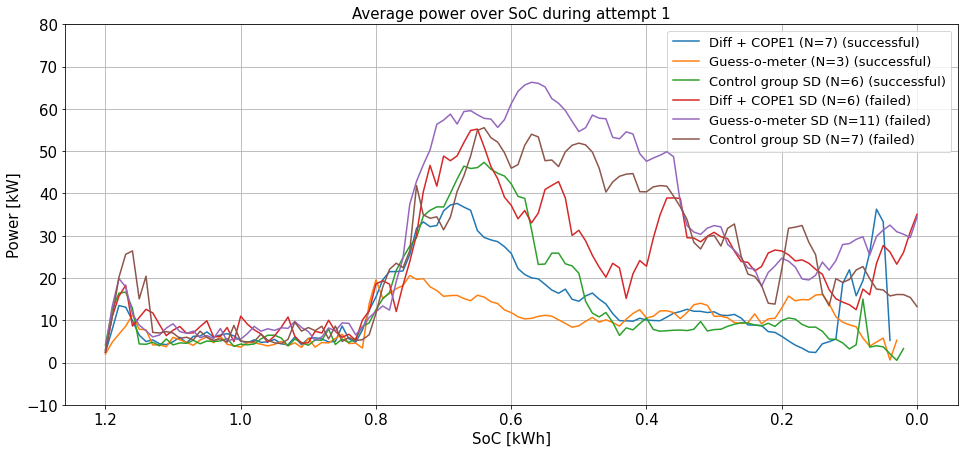

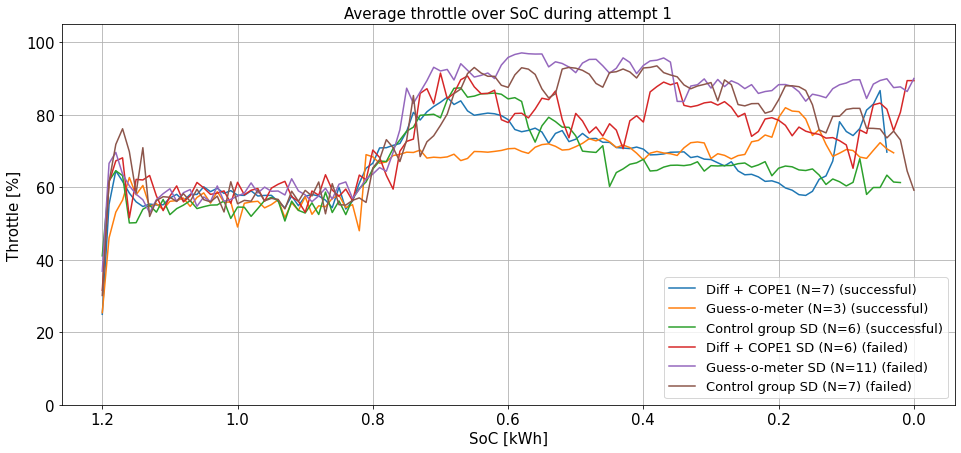

In [124]:
def plotGroupAverage(variable, attempt):
  variable_to_plot = variable
  attempt_nr = attempt

  fig, ax = plt.subplots(figsize=(16,7))

  plus_minus = r'$\pm$'
  
   # Successful
  diff_cope_mean_s = average_groups_successful[(average_groups_successful.evis_id == "diff_and_cope1") & (average_groups_successful.attempt == attempt_nr)]
  individual_count = len(average_individual_successful[(average_individual_successful.evis_id == "diff_and_cope1") & (average_individual_successful.attempt == attempt_nr)].user_id.unique())
  label = "Diff + COPE1 " + plus_minus + " SD (N=" + str(individual_count) + ") (successful)"
  label = "Diff + COPE1 (N=" + str(individual_count) + ") (successful)"
  plt.plot(diff_cope_mean_s["normalizing_window"], diff_cope_mean_s[variable_to_plot], label=label)

  guess_o_meter_mean_s = average_groups_successful[(average_groups_successful.evis_id == "guess_o_meter") & (average_groups_successful.attempt == attempt_nr)]
  individual_count = len(average_individual_successful[(average_individual_successful.evis_id == "guess_o_meter") & (average_individual_successful.attempt == attempt_nr)].user_id.unique())
  label = "Guess-o-meter "+plus_minus+" SD (N=" + str(individual_count) + ") (successful)"
  label = "Guess-o-meter (N=" + str(individual_count) + ") (successful)"
  plt.plot(guess_o_meter_mean_s["normalizing_window"], guess_o_meter_mean_s[variable_to_plot], label=label)

  control_group_mean_s = average_groups_successful[(average_groups_successful.evis_id == "control_group") & (average_groups_successful.attempt == attempt_nr)]
  individual_count = len(average_individual_successful[(average_individual_successful.evis_id == "control_group") & (average_individual_successful.attempt == attempt_nr)].user_id.unique())
  label = "Control group "+plus_minus+" SD (N=" + str(individual_count) + ") (successful)"
  label = "Control group SD (N=" + str(individual_count) + ") (successful)"
  plt.plot(control_group_mean_s["normalizing_window"], control_group_mean_s[variable_to_plot], label=label)
  
  # Failed
  diff_cope_mean_f = average_groups_failed[(average_groups_failed.evis_id == "diff_and_cope1") & (average_groups_failed.attempt == attempt_nr)]
  individual_count = len(average_individual_failed[(average_individual_failed.evis_id == "diff_and_cope1") & (average_individual_failed.attempt == attempt_nr)].user_id.unique())
  label = "Diff + COPE1 " + plus_minus + " SD (N=" + str(individual_count) + ") (failed)"
  label = "Diff + COPE1 SD (N=" + str(individual_count) + ") (failed)"
  plt.plot(diff_cope_mean_f["normalizing_window"], diff_cope_mean_f[variable_to_plot], label=label)

  guess_o_meter_mean_f = average_groups_failed[(average_groups_failed.evis_id == "guess_o_meter") & (average_groups_failed.attempt == attempt_nr)]
  individual_count = len(average_individual_failed[(average_individual_failed.evis_id == "guess_o_meter") & (average_individual_failed.attempt == attempt_nr)].user_id.unique())
  label = "Guess-o-meter "+plus_minus+" SD (N=" + str(individual_count) + ") (failed)"
  label = "Guess-o-meter SD (N=" + str(individual_count) + ") (failed)"
  plt.plot(guess_o_meter_mean_f["normalizing_window"], guess_o_meter_mean_f[variable_to_plot], label=label)

  control_group_mean_f = average_groups_failed[(average_groups_failed.evis_id == "control_group") & (average_groups_failed.attempt == attempt_nr)]
  individual_count = len(average_individual_failed[(average_individual_failed.evis_id == "control_group") & (average_individual_failed.attempt == attempt_nr)].user_id.unique())
  label = "Control group "+plus_minus+" SD (N=" + str(individual_count) + ") (failed)"
  label = "Control group SD (N=" + str(individual_count) + ") (failed)"
  plt.plot(control_group_mean_f["normalizing_window"], control_group_mean_f[variable_to_plot], label=label)
  
  
  
  # plot STD
  """plt.gca().set_prop_cycle(None) # Restarts the color cycle
  std_alpha = 0.1
  
  diff_group_std_f = std_groups_failed[(std_groups_failed.attempt == attempt_nr) & (std_groups_failed.evis_id == "diff_and_cope1")]
  plt.fill_between(
    diff_cope_mean_f["normalizing_window"], 
    diff_cope_mean_f[variable_to_plot] + diff_group_std_f[variable_to_plot],
    diff_cope_mean_f[variable_to_plot] - diff_group_std_f[variable_to_plot],
    alpha=std_alpha)
  
  guess_o_meter_std_f = std_groups_failed[(std_groups_failed.attempt == attempt_nr) & (std_groups_failed.evis_id == "guess_o_meter")]
  plt.fill_between(
    guess_o_meter_mean_f["normalizing_window"], 
    guess_o_meter_mean_f[variable_to_plot] + guess_o_meter_std_f[variable_to_plot],
    guess_o_meter_mean_f[variable_to_plot] - guess_o_meter_std_f[variable_to_plot],
    alpha=std_alpha)
  
  control_group_std_f = std_groups_failed[(std_groups_failed.attempt == attempt_nr) & (std_groups_failed.evis_id == "control_group")]
  plt.fill_between(
    control_group_mean_f["normalizing_window"], 
    control_group_mean_f[variable_to_plot] + control_group_std_f[variable_to_plot],
    control_group_mean_f[variable_to_plot] - control_group_std_f[variable_to_plot],
    alpha=std_alpha)
"""
  # plot fails
  plt.gca().set_prop_cycle(None)
  
  #if not exclude_failed_attempts:
    #failed_diff_and_cope = failed_attempts[(failed_attempts.evis_id == "diff_and_cope1") & (failed_attempts.attempt == attempt_nr)]
    #plt.scatter(failed_diff_and_cope[variable_to_normalize_against], failed_diff_and_cope[variable_to_plot], label="Diff & COPE1 failed attempts")

    #failed_guess = failed_attempts[(failed_attempts.evis_id == "guess_o_meter") & (failed_attempts.attempt == attempt_nr)]
    #plt.scatter(failed_guess[variable_to_normalize_against], failed_guess[variable_to_plot], label="Guess-o-meter failed attempts")

    #failed_control_group = failed_attempts[(failed_attempts.evis_id == "control_group") & (failed_attempts.attempt == attempt_nr)]
    #plt.scatter(failed_control_group[variable_to_normalize_against], failed_control_group[variable_to_plot], label="Control group failed attempts")

  # plot road elevation
  #road_evel_ax = ax.twinx()
  #road_plot = road_evel_ax.plot(road_elevation.distance_window, road_elevation.road_elevation, "--", color="k", label="Road elevation", alpha=0.5)
  #road_evel_ax.set_ylim(-10, 50)
  #road_evel_ax.set_ylabel("Road elevation [m]")
  
  # hlines at speed signs
  #road_evel_ax.vlines(0,-100,200, "tab:olive", linewidth=2.0, linestyles="dotted", alpha=1.0, label="40 km/h road start")
  #road_evel_ax.vlines(3100,-100,200, "tab:cyan", linewidth=2.0, linestyles="dotted", alpha=1.0, label="110 km/h road start")
  #road_evel_ax.vlines(8000,-100,200, "tab:purple", linewidth=2.0, linestyles="dotted", alpha=1.0, label="Charging station")
  
  # Arrows pointing to speed signs
  #road_evel_ax.annotate('40 km/h start', (0, road_elevation.road_elevation[0]),
  #          xytext=(0.2, 0.1), textcoords='axes fraction',
  #          arrowprops=dict(facecolor='black', shrink=0.05),
  #          fontsize=16,
  #          horizontalalignment='right', verticalalignment='top')
  #road_evel_ax.annotate('110 km/h start', (3100, road_elevation.road_elevation[30]),
  #        xytext=(0.58, 0.1), textcoords='axes fraction',
  #        arrowprops=dict(facecolor='black', shrink=0.05),
  #        fontsize=16,
  #        horizontalalignment='right', verticalalignment='top')
  
  # Set figure title
  #tb1 = r"$\bf{" + variables_print_pretty[variable_to_plot].lower() + "}$"
  #tb2 = r"$\bf{" + str(attempt) + "}$"
  ax.set_title("Average " + variables_print_pretty[variable_to_plot].lower() + " over SoC during attempt " + str(attempt))
  
  # Set the y-lim based on what variable we are plotting
  if variable_to_plot == "speed":
    ax.set_ylim(0,130)
  if variable_to_plot == "power_usage":
    ax.set_ylim(-10,80)
  if variable_to_plot == "throttle_position":
    ax.set_ylim(0,105)
 
  #road_evel_ax.legend()
  #ax.legend(loc="upper left")  
  ax.legend()  
  ax.grid(True)
  #ax.set_xlabel("Range estimate [km] (rounded down to whole number in EVIS)")
  ax.set_xlabel("SoC [kWh]")
  ax.set_ylabel(variables_print_pretty[variable_to_plot] + " " + variables_unit[variable_to_plot])
  
  ax.xaxis.set_minor_locator(MultipleLocator(100))
  ax.xaxis.grid(True, which='minor')
  
  #ax.set_xticks(np.arange(0,11,1))
  ax.invert_xaxis()

  
  title = "average_" + variables_print_pretty[variable_to_plot].lower() + "_over_SoC_attempt_" + str(attempt) + " (successful + failed)"
  #plt.savefig("/home/steve/Pictures/figures/only successful attempts/" + title + ".png", dpi=200)
  #title = "sample_distance_"+str(distance_window_size)+"m"
  #plt.savefig("/home/steve/Pictures/figures/01-4/" + title + ".png", dpi=200)

  plt.show()
  
  
variable = "speed"
plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "power_usage"
plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "throttle_position"
plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "current_soc"
#plotGroupAverage(variable, 1)

## Guess o meter SD abruptly stops when there's only one single data point!!!!!

# Successful vs failed in all groups combined

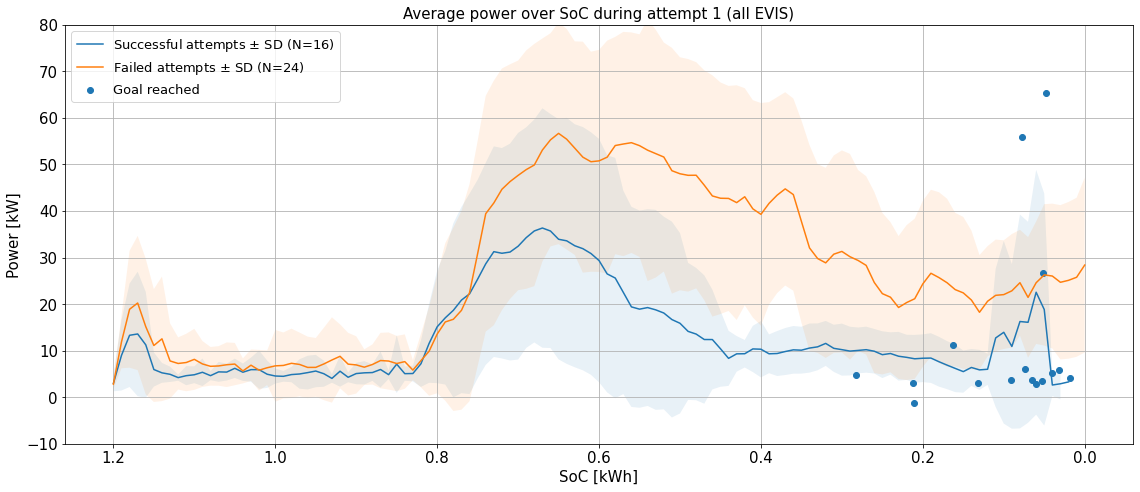

In [20]:
def plotGroupAverage(variable, attempt):
  variable_to_plot = variable
  attempt_nr = attempt

  fig, ax = plt.subplots(figsize=(16,7))

  plus_minus = r'$\pm$'
  
  # Successful
  all_successful_mean = average_all_evis_successful[(average_all_evis_successful.attempt == attempt_nr)]
  individual_count = len(average_individual_successful[(average_individual_successful.attempt == attempt_nr)].user_id.unique())
  label = "Successful attempts $\pm$ SD (N=" + str(individual_count) + ")"
  #label = "Diff + COPE1 (N=" + str(individual_count) + ") (successful)"
  plt.plot(all_successful_mean["normalizing_window"], all_successful_mean[variable_to_plot], label=label)

  
  # Failed
  all_failed_mean = average_all_evis_failed[(average_all_evis_failed.attempt == attempt_nr)]
  individual_count = len(average_individual_failed[(average_individual_failed.attempt == attempt_nr)].user_id.unique())
  label = "Failed attempts $\pm$ SD (N=" + str(individual_count) + ")"
  #label = "Diff + COPE1 (N=" + str(individual_count) + ") (successful)"
  plt.plot(all_failed_mean["normalizing_window"], all_failed_mean[variable_to_plot], label=label)

   
  # plot STD
  plt.gca().set_prop_cycle(None) # Restarts the color cycle
  std_alpha = 0.1

  all_successful_std = std_all_evis_successful[std_all_evis_successful.attempt == attempt_nr]
  plt.fill_between(
    all_successful_mean["normalizing_window"], 
    all_successful_mean[variable_to_plot] + all_successful_std[variable_to_plot],
    all_successful_mean[variable_to_plot] - all_successful_std[variable_to_plot],
    alpha=std_alpha)
  
  all_failed_std = std_all_evis_failed[std_all_evis_failed.attempt == attempt_nr]
  plt.fill_between(
    all_failed_mean["normalizing_window"], 
    all_failed_mean[variable_to_plot] + all_failed_std[variable_to_plot],
    all_failed_mean[variable_to_plot] - all_failed_std[variable_to_plot],
    alpha=std_alpha)

  # plot fails
  plt.gca().set_prop_cycle(None)
  
  success_end = successful_attempts[successful_attempts.attempt == 1].groupby(["user_id"]).head(1)
  plt.scatter(success_end[variable_to_normalize_against], success_end[variable_to_plot], label="Goal reached")
  
  #if not exclude_failed_attempts:
    #failed_diff_and_cope = failed_attempts[(failed_attempts.evis_id == "diff_and_cope1") & (failed_attempts.attempt == attempt_nr)]
    #plt.scatter(failed_diff_and_cope[variable_to_normalize_against], failed_diff_and_cope[variable_to_plot], label="Diff & COPE1 failed attempts")

    #failed_guess = failed_attempts[(failed_attempts.evis_id == "guess_o_meter") & (failed_attempts.attempt == attempt_nr)]
    #plt.scatter(failed_guess[variable_to_normalize_against], failed_guess[variable_to_plot], label="Guess-o-meter failed attempts")

    #failed_control_group = failed_attempts[(failed_attempts.evis_id == "control_group") & (failed_attempts.attempt == attempt_nr)]
    #plt.scatter(failed_control_group[variable_to_normalize_against], failed_control_group[variable_to_plot], label="Control group failed attempts")

  # plot road elevation
  #road_evel_ax = ax.twinx()
  #road_plot = road_evel_ax.plot(road_elevation.distance_window, road_elevation.road_elevation, "--", color="k", label="Road elevation", alpha=0.5)
  #road_evel_ax.set_ylim(-10, 50)
  #road_evel_ax.set_ylabel("Road elevation [m]")
  
  # Set figure title
  ax.set_title("Average " + variables_print_pretty[variable_to_plot].lower() + " over SoC during attempt " + str(attempt)  + " (all EVIS)")
  
  # Set the y-lim based on what variable we are plotting
  if variable_to_plot == "speed":
    ax.set_ylim(0,130)
  if variable_to_plot == "power_usage":
    ax.set_ylim(-10,80)
  if variable_to_plot == "throttle_position":
    ax.set_ylim(0,105)
 
  #road_evel_ax.legend()
  #ax.legend(loc="upper left")  
  ax.legend()  
  ax.grid(True)
  #ax.set_xlabel("Range estimate [km] (rounded down to whole number in EVIS)")
  ax.set_xlabel("SoC [kWh]")
  ax.set_ylabel(variables_print_pretty[variable_to_plot] + " " + variables_unit[variable_to_plot])
  
  ax.xaxis.set_minor_locator(MultipleLocator(100))
  ax.xaxis.grid(True, which='minor')
  
  #ax.set_xticks(np.arange(0,11,1))
  ax.invert_xaxis()
  
  plt.tight_layout()
  #plt.savefig("/home/steve/Pictures/figures/23-4/power_over_soc_all_evis.png", dpi=200)
  #plt.savefig("/home/steve/Pictures/figures/23-4/power_over_soc_all_evis_with_goal_reached.png", dpi=200)

  plt.show()
  
variable = "power_usage"
plotGroupAverage(variable, 1)

# T-test : look for statistical significance

## t-test successful against failed attempts

### Power against SoC

In [324]:
def ttest_independent(samp_1, samp_2):
    # Check if equal variances
    s,p = stats.levene(samp_1, samp_2)
    equal_var = True
    if p < 0.05:
      equal_var = False
    
    s,p = stats.ttest_ind(samp_1, samp_2, equal_var=equal_var)
    
    return {
      "p": round(p, 4),
      "N1": samp_1.count(),
      "N2": samp_2.count(),
      "samp1_mean": round(samp_1.mean(), 2),
      "samp2_mean": round(samp_2.mean(), 2)
    }
    
# Choose which variable to plot here!
#variable = "throttle_position" 
#variable = "speed" 
#variable = "throttle_position"
variable = "power_usage"

dataset_to_use = average_individual_successful
#dataset_2 = average_individual_failed

section_size = np.array([0,0.1])
step_size = 0.05
which_attempt = 1

significant_differences = []

search_sections = [
  [1.1, 1.2],
  [0.05, 1.2],
]

section = section_size.copy()
while section[1] <= 1.21: # Battery capacity
#for section in search_sections:
    #print("Section:", str(section))
    
    successful_a1_all_evis = average_individual_successful[average_individual_successful.attempt == 1]
    successful_a1_all_evis = successful_a1_all_evis.pivot(index="normalizing_window", columns="user_id", values=variable)
    successful_a1_all_evis_mean = successful_a1_all_evis.loc[section[0]:section[1]].dropna(axis=1).mean()
    
    failed_a1_all_evis = average_individual_failed[average_individual_failed.attempt == 1]
    failed_a1_all_evis = failed_a1_all_evis.pivot(index="normalizing_window", columns="user_id", values=variable)
    failed_a1_all_evis_mean = failed_a1_all_evis.loc[section[0]:section[1]].dropna(axis=1).mean()
    
    t_test__successful_vs_failed = ttest_independent(successful_a1_all_evis_mean, failed_a1_all_evis_mean)
    
    if t_test__successful_vs_failed["p"] <= 0.05:
      #print("\tsignificant")
      significant_differences.append({
          "section":section.copy(), 
          "p-value": t_test__successful_vs_failed["p"], 
          "N successful": t_test__successful_vs_failed["N1"], 
          "N failed": t_test__successful_vs_failed["N2"],
          "successful mean": t_test__successful_vs_failed["samp1_mean"],
          "failed mean": t_test__successful_vs_failed["samp2_mean"]
        })
      print(significant_differences[-1])
    if type(section) == np.ndarray:
      section += step_size
print("Done")

/home/steve/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/steve/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'section': array([0.1, 0.2]), 'p-value': 0.0, 'N successful': 11, 'N failed': 24, 'successful mean': 8.27, 'failed mean': 22.77}
{'section': array([0.15, 0.25]), 'p-value': 0.0001, 'N successful': 13, 'N failed': 24, 'successful mean': 8.63, 'failed mean': 22.88}
{'section': array([0.2, 0.3]), 'p-value': 0.0001, 'N successful': 13, 'N failed': 24, 'successful mean': 10.3, 'failed mean': 24.79}
{'section': array([0.25, 0.35]), 'p-value': 0.0001, 'N successful': 15, 'N failed': 24, 'successful mean': 10.59, 'failed mean': 28.75}
{'section': array([0.3, 0.4]), 'p-value': 0.0, 'N successful': 16, 'N failed': 24, 'successful mean': 10.25, 'failed mean': 36.38}
{'section': array([0.35, 0.45]), 'p-value': 0.0, 'N successful': 16, 'N failed': 24, 'successful mean': 9.65, 'failed mean': 41.83}
{'section': array([0.4, 0.5]), 'p-value': 0.0, 'N successful': 16, 'N failed': 24, 'successful mean': 11.06, 'failed mean': 43.41}
{'section': array([0.45, 0.55]), 'p-value': 0.0, 'N successful': 16, 'N 

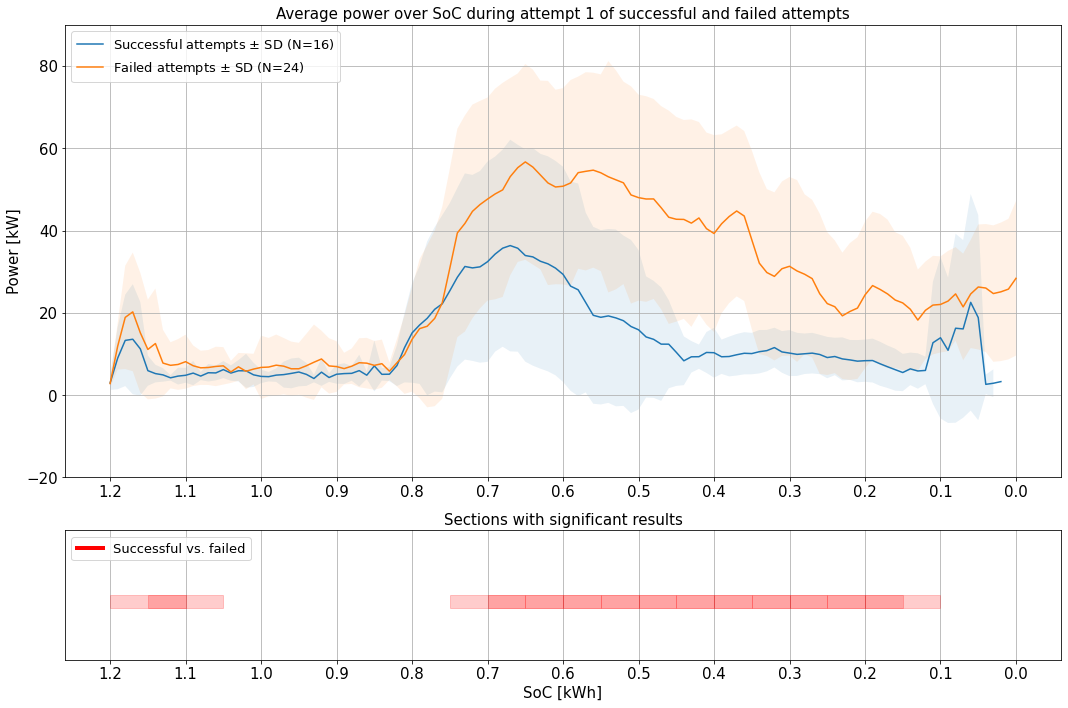

In [327]:
def plotGroupAverage(variable, attempt):
  variable_to_plot = variable
  attempt_nr = attempt

  #fig, ax = plt.subplots()
  fig, (ax, ax2) = plt.subplots(2,1,figsize=(15,10),gridspec_kw={'height_ratios': [3.5, 1]})

  # Successful
  all_successful_mean = average_all_evis_successful[(average_all_evis_successful.attempt == attempt_nr)]
  individual_count = len(average_individual_successful[(average_individual_successful.attempt == attempt_nr)].user_id.unique())
  label = "Successful attempts $\pm$ SD (N=" + str(individual_count) + ")"
  ax.plot(all_successful_mean["normalizing_window"], all_successful_mean[variable_to_plot], label=label)

  # Failed
  all_failed_mean = average_all_evis_failed[(average_all_evis_failed.attempt == attempt_nr)]
  individual_count = len(average_individual_failed[(average_individual_failed.attempt == attempt_nr)].user_id.unique())
  label = "Failed attempts $\pm$ SD (N=" + str(individual_count) + ")"
  ax.plot(all_failed_mean["normalizing_window"], all_failed_mean[variable_to_plot], label=label)

   
  # plot STD
  plt.gca().set_prop_cycle(None) # Restarts the color cycle
  std_alpha = 0.1

  all_successful_std = std_all_evis_successful[std_all_evis_successful.attempt == attempt_nr]
  ax.fill_between(
    all_successful_mean["normalizing_window"], 
    all_successful_mean[variable_to_plot] + all_successful_std[variable_to_plot],
    all_successful_mean[variable_to_plot] - all_successful_std[variable_to_plot],
    alpha=std_alpha)
  
  all_failed_std = std_all_evis_failed[std_all_evis_failed.attempt == attempt_nr]
  ax.fill_between(
    all_failed_mean["normalizing_window"], 
    all_failed_mean[variable_to_plot] + all_failed_std[variable_to_plot],
    all_failed_mean[variable_to_plot] - all_failed_std[variable_to_plot],
    alpha=std_alpha)
 
  ax.set_title("Average " + variables_print_pretty[variable_to_plot].lower() + " over SoC during attempt " + str(attempt) + " of successful and failed attempts")
  
  
  # Adjust y-range depending on variable
  if variable_to_plot == "speed":
    ax.set_ylim(0,130)
  if variable_to_plot == "power_usage":
    ax.set_ylim(-20,90)
  if variable_to_plot == "throttle_position":
    ax.set_ylim(0,105)
    
  ax.grid(True)
  ax2.set_xlabel("SoC [kWh]")
  ax.set_ylabel(variables_print_pretty[variable_to_plot] + " " + variables_unit[variable_to_plot])
  ax.set_xticks(np.arange(0, 1.21, step=0.1))
  ax.invert_xaxis()
  
  ### Show significant differences ###
  thicknes = 0.1
  spacing = 0.1
  start_y = 0.5
  padding = 0.06
  ax2.set_xlim(0-padding,1.2+padding)
  ax2.get_yaxis().set_visible(False)
  ax2.grid(True)
  ax2.set_title("Sections with significant results")
  ax2.set_xticks(np.arange(0, 1.21, step=0.1))
  ax2.invert_xaxis()
  
  for difference in significant_differences:
    start_x = difference["section"][0]
    end_x = difference["section"][1]
    end_y = start_y + thicknes
    alpha = 0.2
    
    rect = Rectangle((start_x, start_y-thicknes), 
                 end_x-start_x, end_y-start_y, 
                 fill=True, 
                 zorder=100,
                 alpha=alpha,
                 color="red")
    
    ax2.add_patch(rect)  

  custom_lines = Line2D([0], [0], color="red", lw=4),
  
  ax2.legend(custom_lines, ['Successful vs. failed'], loc="upper left")
  
  ax.legend(loc="upper left")
  
  plt.tight_layout()
  #plt.savefig("/home/steve/Pictures/figures/19-4/successful-vs-failed-power-over-soc[1.2,0.05].png", dpi=200)  
  #plt.savefig("/home/steve/Pictures/figures/19-4/successful-vs-failed-power-over-soc-search.png", dpi=200)  
  plt.show()

  
  
#!!!! Make sure to only plot the variable which we are checking for significant differences on in the cell above!!!!  
plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)

### Speed against SoC <---

In [320]:
def ttest_independent(samp_1, samp_2):
    # Check if equal variances
    s,p = stats.levene(samp_1, samp_2)
    equal_var = True
    if p < 0.05:
      equal_var = False
    
    s,p = stats.ttest_ind(samp_1, samp_2, equal_var=equal_var)
    
    return {
      "p": round(p, 4),
      "N1": samp_1.count(),
      "N2": samp_2.count(),
      "samp1_mean": round(samp_1.mean(), 2),
      "samp2_mean": round(samp_2.mean(), 2)
    }
    
# Choose which variable to plot here!
#variable = "throttle_position" 
variable = "speed" 
#variable = "throttle_position"
#variable = "power_usage"

dataset_to_use = average_individual_successful
#dataset_2 = average_individual_failed

section_size = np.array([0,0.1])
step_size = 0.05
which_attempt = 1

significant_differences = []


search_sections = [
  [0.1, 1.2],
]


section = section_size.copy()
while section[1] <= 1.21: # Battery capacity
#for section in search_sections:
    #print("Section:", str(section))
    
    successful_a1_all_evis = average_individual_successful[average_individual_successful.attempt == 1]
    successful_a1_all_evis = successful_a1_all_evis.pivot(index="normalizing_window", columns="user_id", values=variable)
    successful_a1_all_evis_mean = successful_a1_all_evis.loc[section[0]:section[1]].dropna(axis=1).mean()
    
    failed_a1_all_evis = average_individual_failed[average_individual_failed.attempt == 1]
    failed_a1_all_evis = failed_a1_all_evis.pivot(index="normalizing_window", columns="user_id", values=variable)
    failed_a1_all_evis_mean = failed_a1_all_evis.loc[section[0]:section[1]].dropna(axis=1).mean()
    
    t_test__successful_vs_failed = ttest_independent(successful_a1_all_evis_mean, failed_a1_all_evis_mean)
    
    if t_test__successful_vs_failed["p"] <= 0.05:
      #print("\tsignificant")
      significant_differences.append({
          "section":section.copy(), 
          "p-value": t_test__successful_vs_failed["p"], 
          "N successful": t_test__successful_vs_failed["N1"], 
          "N failed": t_test__successful_vs_failed["N2"],
          "successful mean": t_test__successful_vs_failed["samp1_mean"],
          "failed mean": t_test__successful_vs_failed["samp2_mean"]
        })
      print(significant_differences[-1])
    if type(section) == np.ndarray:
      section += step_size
print("Done")

/home/steve/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/steve/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'section': array([0.05, 0.15]), 'p-value': 0.0166, 'N successful': 6, 'N failed': 24, 'successful mean': 57.97, 'failed mean': 79.56}
{'section': array([0.1, 0.2]), 'p-value': 0.0, 'N successful': 11, 'N failed': 24, 'successful mean': 51.24, 'failed mean': 80.94}
{'section': array([0.15, 0.25]), 'p-value': 0.0, 'N successful': 13, 'N failed': 24, 'successful mean': 51.61, 'failed mean': 83.17}
{'section': array([0.2, 0.3]), 'p-value': 0.0, 'N successful': 13, 'N failed': 24, 'successful mean': 53.55, 'failed mean': 84.93}
{'section': array([0.25, 0.35]), 'p-value': 0.0, 'N successful': 15, 'N failed': 24, 'successful mean': 54.71, 'failed mean': 87.12}
{'section': array([0.3, 0.4]), 'p-value': 0.0, 'N successful': 16, 'N failed': 24, 'successful mean': 55.4, 'failed mean': 89.04}
{'section': array([0.35, 0.45]), 'p-value': 0.0, 'N successful': 16, 'N failed': 24, 'successful mean': 57.11, 'failed mean': 88.13}
{'section': array([0.4, 0.5]), 'p-value': 0.0002, 'N successful': 16, 'N f

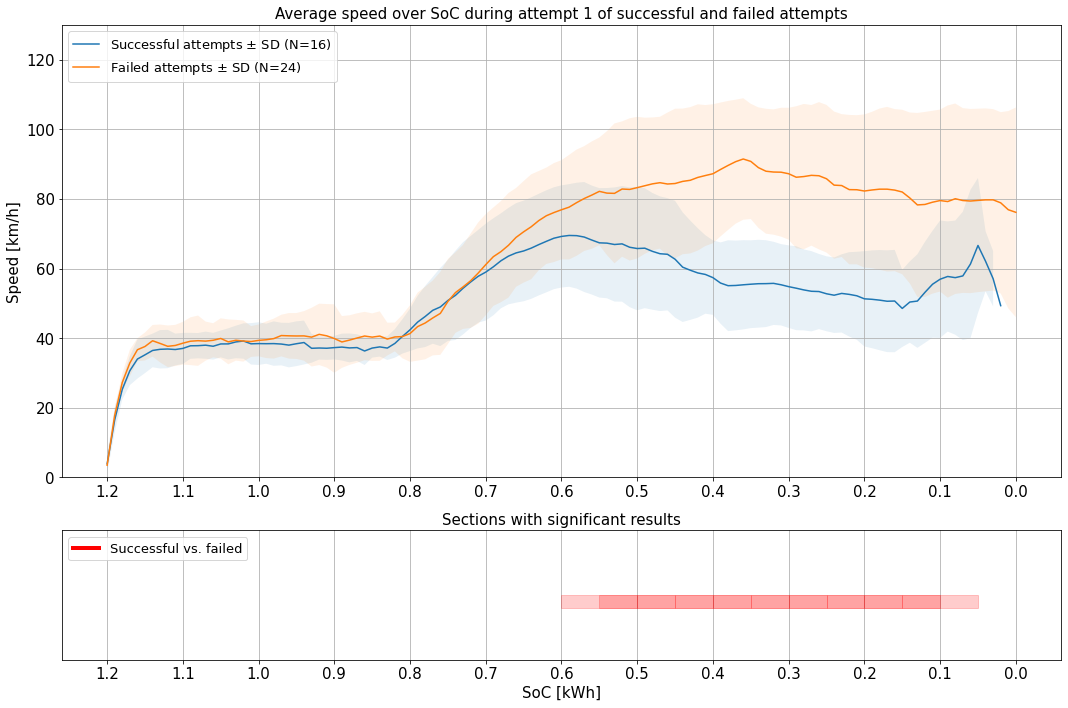

In [322]:
def plotGroupAverage(variable, attempt):
  variable_to_plot = variable
  attempt_nr = attempt

  #fig, ax = plt.subplots()
  fig, (ax, ax2) = plt.subplots(2,1,figsize=(15,10),gridspec_kw={'height_ratios': [3.5, 1]})

  # Successful
  all_successful_mean = average_all_evis_successful[(average_all_evis_successful.attempt == attempt_nr)]
  individual_count = len(average_individual_successful[(average_individual_successful.attempt == attempt_nr)].user_id.unique())
  label = "Successful attempts $\pm$ SD (N=" + str(individual_count) + ")"
  ax.plot(all_successful_mean["normalizing_window"], all_successful_mean[variable_to_plot], label=label)

  # Failed
  all_failed_mean = average_all_evis_failed[(average_all_evis_failed.attempt == attempt_nr)]
  individual_count = len(average_individual_failed[(average_individual_failed.attempt == attempt_nr)].user_id.unique())
  label = "Failed attempts $\pm$ SD (N=" + str(individual_count) + ")"
  ax.plot(all_failed_mean["normalizing_window"], all_failed_mean[variable_to_plot], label=label)

   
  # plot STD
  plt.gca().set_prop_cycle(None) # Restarts the color cycle
  std_alpha = 0.1

  all_successful_std = std_all_evis_successful[std_all_evis_successful.attempt == attempt_nr]
  ax.fill_between(
    all_successful_mean["normalizing_window"], 
    all_successful_mean[variable_to_plot] + all_successful_std[variable_to_plot],
    all_successful_mean[variable_to_plot] - all_successful_std[variable_to_plot],
    alpha=std_alpha)
  
  all_failed_std = std_all_evis_failed[std_all_evis_failed.attempt == attempt_nr]
  ax.fill_between(
    all_failed_mean["normalizing_window"], 
    all_failed_mean[variable_to_plot] + all_failed_std[variable_to_plot],
    all_failed_mean[variable_to_plot] - all_failed_std[variable_to_plot],
    alpha=std_alpha)
 
  ax.set_title("Average " + variables_print_pretty[variable_to_plot].lower() + " over SoC during attempt " + str(attempt) + " of successful and failed attempts")
  
  
  # Adjust y-range depending on variable
  if variable_to_plot == "speed":
    ax.set_ylim(0,130)
  if variable_to_plot == "power_usage":
    ax.set_ylim(-20,90)
  if variable_to_plot == "throttle_position":
    ax.set_ylim(0,105)
    
  ax.grid(True)
  ax2.set_xlabel("SoC [kWh]")
  ax.set_ylabel(variables_print_pretty[variable_to_plot] + " " + variables_unit[variable_to_plot])
  ax.set_xticks(np.arange(0, 1.21, step=0.1))
  ax.invert_xaxis()
  
  ### Show significant differences ###
  thicknes = 0.1
  spacing = 0.1
  start_y = 0.5
  padding = 0.06
  ax2.set_xlim(0-padding,1.2+padding)
  ax2.get_yaxis().set_visible(False)
  ax2.grid(True)
  ax2.set_title("Sections with significant results")
  ax2.set_xticks(np.arange(0, 1.21, step=0.1))
  ax2.invert_xaxis()
  
  for difference in significant_differences:
    start_x = difference["section"][0]
    end_x = difference["section"][1]
    end_y = start_y + thicknes
    alpha = 0.2
    
    rect = Rectangle((start_x, start_y-thicknes), 
                 end_x-start_x, end_y-start_y, 
                 fill=True, 
                 zorder=100,
                 alpha=alpha,
                 color="red")
    
    ax2.add_patch(rect)  

  custom_lines = Line2D([0], [0], color="red", lw=4),
  
  ax2.legend(custom_lines, ['Successful vs. failed'], loc="upper left")
  
  ax.legend(loc="upper left")
  
  plt.tight_layout()
  
  plt.savefig("/home/steve/Pictures/figures/19-4/successful-vs-failed-speed-over-soc-search.png", dpi=200)  
  
  plt.show()
  
#!!!! Make sure to only plot the variable which we are checking for significant differences on in the cell above!!!!  
plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)

## Throttle over SoC

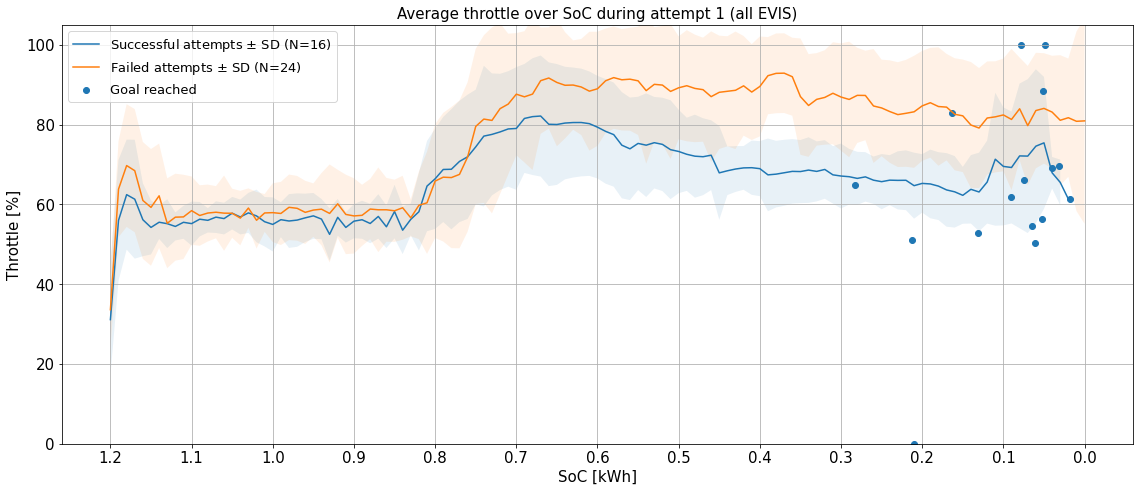

In [33]:
def plotGroupAverage(variable, attempt):
  variable_to_plot = variable
  attempt_nr = attempt

  fig, ax = plt.subplots(figsize=(16,7))

  plus_minus = r'$\pm$'
  
  # Successful
  all_successful_mean = average_all_evis_successful[(average_all_evis_successful.attempt == attempt_nr)]
  individual_count = len(average_individual_successful[(average_individual_successful.attempt == attempt_nr)].user_id.unique())
  label = "Successful attempts $\pm$ SD (N=" + str(individual_count) + ")"
  #label = "Diff + COPE1 (N=" + str(individual_count) + ") (successful)"
  plt.plot(all_successful_mean["normalizing_window"], all_successful_mean[variable_to_plot], label=label)

  
  # Failed
  all_failed_mean = average_all_evis_failed[(average_all_evis_failed.attempt == attempt_nr)]
  individual_count = len(average_individual_failed[(average_individual_failed.attempt == attempt_nr)].user_id.unique())
  label = "Failed attempts $\pm$ SD (N=" + str(individual_count) + ")"
  #label = "Diff + COPE1 (N=" + str(individual_count) + ") (successful)"
  plt.plot(all_failed_mean["normalizing_window"], all_failed_mean[variable_to_plot], label=label)

   
  # plot STD
  plt.gca().set_prop_cycle(None) # Restarts the color cycle
  std_alpha = 0.1

  all_successful_std = std_all_evis_successful[std_all_evis_successful.attempt == attempt_nr]
  plt.fill_between(
    all_successful_mean["normalizing_window"], 
    all_successful_mean[variable_to_plot] + all_successful_std[variable_to_plot],
    all_successful_mean[variable_to_plot] - all_successful_std[variable_to_plot],
    alpha=std_alpha)
  
  all_failed_std = std_all_evis_failed[std_all_evis_failed.attempt == attempt_nr]
  plt.fill_between(
    all_failed_mean["normalizing_window"], 
    all_failed_mean[variable_to_plot] + all_failed_std[variable_to_plot],
    all_failed_mean[variable_to_plot] - all_failed_std[variable_to_plot],
    alpha=std_alpha)

  # plot fails
  plt.gca().set_prop_cycle(None)
  
  success_end = successful_attempts[successful_attempts.attempt == 1].groupby(["user_id"]).head(1)
  plt.scatter(success_end[variable_to_normalize_against], success_end[variable_to_plot], label="Goal reached")
  
  #if not exclude_failed_attempts:
    #failed_diff_and_cope = failed_attempts[(failed_attempts.evis_id == "diff_and_cope1") & (failed_attempts.attempt == attempt_nr)]
    #plt.scatter(failed_diff_and_cope[variable_to_normalize_against], failed_diff_and_cope[variable_to_plot], label="Diff & COPE1 failed attempts")

    #failed_guess = failed_attempts[(failed_attempts.evis_id == "guess_o_meter") & (failed_attempts.attempt == attempt_nr)]
    #plt.scatter(failed_guess[variable_to_normalize_against], failed_guess[variable_to_plot], label="Guess-o-meter failed attempts")

    #failed_control_group = failed_attempts[(failed_attempts.evis_id == "control_group") & (failed_attempts.attempt == attempt_nr)]
    #plt.scatter(failed_control_group[variable_to_normalize_against], failed_control_group[variable_to_plot], label="Control group failed attempts")

  # plot road elevation
  #road_evel_ax = ax.twinx()
  #road_plot = road_evel_ax.plot(road_elevation.distance_window, road_elevation.road_elevation, "--", color="k", label="Road elevation", alpha=0.5)
  #road_evel_ax.set_ylim(-10, 50)
  #road_evel_ax.set_ylabel("Road elevation [m]")
  
  # Set figure title
  ax.set_title("Average " + variables_print_pretty[variable_to_plot].lower() + " over SoC during attempt " + str(attempt)  + " (all EVIS)")
  
  # Set the y-lim based on what variable we are plotting
  if variable_to_plot == "speed":
    ax.set_ylim(0,130)
  if variable_to_plot == "power_usage":
    ax.set_ylim(-10,80)
  if variable_to_plot == "throttle_position":
    ax.set_ylim(0,105)
 
  #road_evel_ax.legend()
  ax.legend(loc="upper left")  
  #ax.legend()  
  ax.grid(True)
  #ax.set_xlabel("Range estimate [km] (rounded down to whole number in EVIS)")
  ax.set_xlabel("SoC [kWh]")
  ax.set_ylabel(variables_print_pretty[variable_to_plot] + " " + variables_unit[variable_to_plot])
  
  ax.xaxis.set_minor_locator(MultipleLocator(100))
  ax.xaxis.grid(True, which='minor')
  
  ax.set_xticks(np.arange(0,1.21,0.1))
  ax.invert_xaxis()
  
  plt.tight_layout()
  #plt.savefig("/home/steve/Pictures/figures/23-4/throttle_over_soc_all_evis.png", dpi=200)
  plt.savefig("/home/steve/Pictures/figures/23-4/throttle_over_soc_all_evis_with_goal_reached.png", dpi=200)

  plt.show()
  
variable = "throttle_position"
plotGroupAverage(variable, 1)

## Plot EVIS individually

In [ ]:
params = {
    'font.size': 12,
    'axes.labelsize': 15,
    'axes.titlesize': 15,
    'legend.fontsize': 12,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15
}
matplotlib.rcParams.update(params)

def plotIndividualAverages(variable, attempt, save_images):
  variable_to_plot = variable
  attempt_nr = attempt

  fig, ax = plt.subplots(figsize=(15,7))

  groups_average = average_groups[average_groups.attempt == attempt_nr]

  # Speed mean
  diff_cope_mean_1 = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == 1)]
  plt.plot(diff_cope_mean_1.distance_window, diff_cope_mean_1[variable_to_plot], label="Diff & COPE1 Mean Attempt 1")
  
  diff_cope_mean_2 = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == 2)]
  plt.plot(diff_cope_mean_2.distance_window, diff_cope_mean_2[variable_to_plot], label="Diff & COPE1 Mean Attempt 2")
   
  # speed STD
  plt.gca().set_prop_cycle(None) # Restarts the color cycle
  std_alpha = 0.1
  for i in range(2):
    diff_cope_mean = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == i+1)]
    diff_group_std = std_groups[(std_groups.attempt == i+1) & (std_groups.evis_id == "diff_and_cope1")]
    plt.fill_between(
      diff_group_std.distance_window, 
      diff_cope_mean[variable_to_plot] + diff_group_std[variable_to_plot],
      diff_cope_mean[variable_to_plot] - diff_group_std[variable_to_plot],
      alpha=std_alpha, label="Diff & COPE1 STD attempt " + str(i+1))
  
  # Fails
  plt.gca().set_prop_cycle(None)

  for i in range(2):
    failed_diff_and_cope = failed_attempts[(failed_attempts.evis_id == "diff_and_cope1") & (failed_attempts.attempt == i+1)]
    plt.scatter(failed_diff_and_cope.distance_traveled, failed_diff_and_cope[variable_to_plot], label="Diff & COPE1 fails attempt " + str(i+1))

  # Road elevation
  road_evel_ax = ax.twinx()
  road_plot = road_evel_ax.plot(road_elevation.distance_window, road_elevation.road_elevation, "--", color="k", label="Road elevation", alpha=0.5)
  road_evel_ax.set_ylim(-10, 50)
  road_evel_ax.set_ylabel("Road elevation [m]")
  
  title = "Average " + str(variable_to_plot) + " during attempt " + str(attempt_nr)
  plt.title(title)
  ax.legend(loc="upper left")
  #ax.set_ylim(0,130)
  road_evel_ax.legend()
  ax.grid(True)
  ax.set_xlabel("Distance traveled [m]")
  ax.set_ylabel(str(variable_to_plot) + " [km/h]")

  if save_images:
    plt.savefig("/home/steve/Pictures/figures/" + title + ".png", dpi=200)

  plt.show()
  
  
save_images = False
variable = "speed"
#plotIndividualAverages(variable, 1, save_images)
#plotIndividualAverages(variable, 2, save_images)

## Plot each driver individually
Here I plot each user's first and second attempt in individual plots

In [97]:
params = {
    'font.size': 12,
    'axes.labelsize': 15,
    'axes.titlesize': 15,
    'legend.fontsize': 12,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15
}

matplotlib.rcParams.update(params)

def plotIndividualAverages(variable, save_images):
  variable_to_plot = variable
  
  counter = 0
  
  for id, data in average_individual.groupby(["user_id"]):
    fig, ax = plt.subplots(figsize=(15,7))
    
    evis = data["evis_id"].iloc[0] # Get which evis the driver is using
    attempt = data["attempt"].iloc[0] # Get which attempt
    
    a1 = data[data["attempt"] == 1]
    a2 = data[data["attempt"] == 2]
    
    plt.plot(a1.distance_window, a1[variable_to_plot] * 100, label="Attempt #1")
    plt.plot(a2.distance_window, a2[variable_to_plot] * 100, label="Attempt #2")
    
    # Road elevation
    ax_secondary = ax.twinx()
    ax_secondary.plot(road_elevation.distance_window, road_elevation.road_elevation, "--", color="k", label="Road elevation", alpha=0.3)
    ax_secondary.set_ylim(-10, 50)
    ax_secondary.set_ylabel("Road elevation [m]")
    
    ax_secondary.vlines(0,-100,200, "tab:olive", linewidth=2.0, linestyles="dotted", alpha=1.0, label="40 km/h road start")
    ax_secondary.vlines(3100,-100,200, "tab:cyan", linewidth=2.0, linestyles="dotted", alpha=1.0, label="110 km/h road start")
    ax_secondary.vlines(8000,-100,200, "tab:purple", linewidth=2.0, linestyles="dotted", alpha=1.0, label="Charging station")
        
    #tb1 = r"$\bf{" + str(variable_to_plot.capitalize()) + "}$"
    tb1 = r"$\bf{" + "Throttle" + "}$"
    tb2 = r"$\bf{" + "distance" + "}$"
    tb3 = r"$\bf{" + str(id) + "}$"
    tb4 = r"$\bf{" + variables_print_pretty[evis] + "}$"
    if(evis == "control_group"):
      evis_temp = variables_print_pretty[evis].split(" ")
      tb4 = r"$\bf{" + evis_temp[0] + "}$" + " " + r"$\bf{" + evis_temp[1] + "}$"
    
    ax.set_title(tb1 + " over " + tb2 + " for user with id " + tb3 + " using EVIS " + tb4)
    
    ax.grid(True)
    ax.set_xlabel("Distance traveled [km/h]")
    ax.set_ylabel("Throttle [%]")
    ax.set_ylim(0,105)
    #ax.set_ylim(0,1)
    ax.legend(loc="upper left", framealpha=1).set_zorder(200)
    ax_secondary.legend(loc="lower left", framealpha=1).set_zorder(100)
    plt.tight_layout()
    
    ax.set_zorder(1)
    ax_secondary.set_zorder(2)
    
    if True:
      file_name = str(id) + "_" + str(evis) + "_" + str(variable_to_plot)
      plt.savefig("/home/steve/Pictures/figures/individual_attempts/throttle/" + file_name + ".png", dpi=200)

    
    counter += 1

    #if counter > 2:
    #  return
  
  
save_images = False
variable = "throttle_position"
#plotIndividualAverages(variable, save_images)


## Check averages over specific sections

In [98]:
def getSectionSpecificData(window, evis, attempt):   
  # Select all individual drives within the given distance window span, evis, and attempt nr
  return average_individual[
    (average_individual.distance_window > window[0]) & (average_individual.distance_window < window[1]) &
    (average_individual.evis_id == evis) &
    (average_individual.attempt == attempt)
  ].copy()

# Choose which section
#sections = [[0, 3100], [3100, 6350], [6350, 8000]]
sections = [[3100, 3300], [5000,5500], [7500,8000]]

mean_std_data_frames = []
for j,section in enumerate(sections):
  # Get the values for both diff & guess at attempt 1 & 2
  for evis in ["diff_and_cope1", "guess_o_meter", "control_group"]:
    for i in range(2):
      # Get the data from each user for the specific section
      section_data = getSectionSpecificData(section, evis, i+1)
      
      # Calculate the average over the specific section for all whom used a specific EVIS
      average_section = section_data.groupby(["attempt", "evis_id"], as_index=False).mean()
      average_section["section"] = str(section)
      average_section["data_type"] = "mean"
      
      # Calculate the std over the specific section
      std_section = section_data.groupby(["attempt", "evis_id"], as_index=False).std()
      std_section["section"] = str(section)
      std_section["data_type"] = "std"
      
      mean_std_data_frames.append(average_section)
      mean_std_data_frames.append(std_section)
        
final_data = pd.concat(mean_std_data_frames)

## PLOT ###

fig_bar, ax_bar = plt.subplots(figsize=(9, 10))

x_pos = np.arange(len(sections))
width = 0.2
capsize=10
variable_to_plot = "power_usage"

### Attempt #1 ###

evis = "diff_and_cope1"
a1_diff_mean = final_data[(final_data.evis_id == evis) & (final_data.attempt == 1) & (final_data.data_type == "mean")]
a1_diff_std = final_data[(final_data.evis_id == evis) & (final_data.attempt == 1) & (final_data.data_type == "std")]

#ax_bar.bar(x_pos - (width*2 + width/2) - (width*0.2), 
ax_bar.bar(x_pos - width, 
      a1_diff_mean[variable_to_plot], 
      yerr=a1_diff_std[variable_to_plot], 
      width=width, 
      label="Diff + COPE1 attempt #1", 
      hatch="", capsize=capsize,
      zorder=3)

evis = "guess_o_meter"
a1_guess_mean = final_data[(final_data.evis_id == evis) & (final_data.attempt == 1) & (final_data.data_type == "mean")]
a1_guess_std = final_data[(final_data.evis_id == evis) & (final_data.attempt == 1) & (final_data.data_type == "std")]

#ax_bar.bar(x_pos - (width + width/2) - (width*0.2), 
ax_bar.bar(x_pos, 
      a1_guess_mean[variable_to_plot], 
      yerr=a1_guess_std[variable_to_plot], 
      width=width, 
      label="Guess-o-meter attempt #1", 
      hatch="", capsize=capsize,
      zorder=3)

evis = "control_group"
a1_control_mean = final_data[(final_data.evis_id == evis) & (final_data.attempt == 1) & (final_data.data_type == "mean")]
a1_control_std = final_data[(final_data.evis_id == evis) & (final_data.attempt == 1) & (final_data.data_type == "std")]

#ax_bar.bar(x_pos - (width*0 + width/2)- (width*0.2), 
ax_bar.bar(x_pos + width, 
      a1_control_mean[variable_to_plot], 
      yerr=a1_control_std[variable_to_plot], 
      width=width, 
      label="Control group attempt #1", 
      hatch="", capsize=capsize,
      zorder=3)


### Attempt #2 ###
if False:
  plt.gca().set_prop_cycle(None)

  evis = "diff_and_cope1"
  attempt = 2
  a1_diff_mean = final_data[(final_data.evis_id == evis) & (final_data.attempt == attempt) & (final_data.data_type == "mean")]
  a1_diff_std = final_data[(final_data.evis_id == evis) & (final_data.attempt == attempt) & (final_data.data_type == "std")]

  ax_bar.bar(x_pos + (width*0 + width/2) + (width*0.2), 
        a1_diff_mean[variable_to_plot], 
        yerr=a1_diff_std[variable_to_plot], 
        width=width, 
        label="Diff + COPE1 attempt #2", 
        capsize=capsize,
        zorder=3)

  evis = "guess_o_meter"
  a1_guess_mean = final_data[(final_data.evis_id == evis) & (final_data.attempt == attempt) & (final_data.data_type == "mean")]
  a1_guess_std = final_data[(final_data.evis_id == evis) & (final_data.attempt == attempt) & (final_data.data_type == "std")]

  ax_bar.bar(x_pos + (width + width/2)+ (width*0.2), 
        a1_guess_mean[variable_to_plot], 
        yerr=a1_guess_std[variable_to_plot], 
        width=width, 
        label="Guess-o-meter attempt #2", 
        capsize=capsize,
        zorder=3)

  evis = "control_group"
  a1_control_mean = final_data[(final_data.evis_id == evis) & (final_data.attempt == attempt) & (final_data.data_type == "mean")]
  a1_control_std = final_data[(final_data.evis_id == evis) & (final_data.attempt == attempt) & (final_data.data_type == "std")]

  ax_bar.bar(x_pos + (width*2 + width/2)+ (width*0.2), 
        a1_control_mean[variable_to_plot], 
        yerr=a1_control_std[variable_to_plot], 
        width=width, 
        label="Control group #2", 
        capsize=capsize,
        zorder=3)

ax_bar.grid(True, axis="y",zorder=0)
ax_bar.set_xlabel("Section [m]")
ax_bar.set_ylabel(str(variables_print_pretty[variable_to_plot]).lower()+" "+str(variables_unit[variable_to_plot]))
plt.xticks(np.arange(len(sections)), [str(x) for x in sections])
plt.title("Average " + str(variables_print_pretty[variable_to_plot]).lower() + " over section")
#plt.ylim(0,100)

plt.legend(loc="upper right")
plt.tight_layout()

#title = "average_"+str(variables_print_pretty[variable_to_plot]).lower()+"_over_[3100,4000]_a1_only"
title = "TEST_2"
#plt.savefig("/home/steve/Pictures/" + title + ".png", dpi=200)

plt.show()

AttributeError: 'DataFrame' object has no attribute 'distance_window'

In [183]:
variable = "speed"

which_attempt = 1

# All the averaged values for each individual
individual = average_individual_successful[average_individual_successful.attempt == which_attempt] # Get one particular attempt and evis values
a1_mean_successful = individual.pivot(index="normalizing_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user

individual = average_individual_failed[average_individual_failed.attempt == which_attempt] # Get one particular attempt and evis values
a1_mean_failed = individual.pivot(index="normalizing_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user


def ttest_independent(samp_1, samp_2):
    print("Sample 1 has " + str(samp_1.count()) + " entries")
    print("Sample 2 has " + str(samp_2.count()) + " entries")
    
    s,p = stats.levene(samp_1, samp_2)
    equal_var = True
    if p < 0.05:
      equal_var = False
    
    s,p = stats.ttest_ind(samp_1, samp_2, equal_var=equal_var)
    print("p-value: " + str(round(p,3)))
    if p < 0.05:
        display(Markdown("<font color='green'>There is a statistical difference between the means</font>"))
    else:
        print("No statistical difference between the means")
    print("-"*20)

    
def ttest_range(sections):

  for section in sections:
      print("section: " + str(section))

      display(a1_mean_successful)
      
      # Get the mean speeds at the given section. Also remove users who'm didn't complete the given range
      a1_mean_successful_section = a1_mean_successful.loc[section[0]:section[1]].dropna(axis=1).mean()
      a1_mean_failed_section = a1_mean_failed.loc[section[0]:section[1]].dropna(axis=1).mean()
      
      display(a1_mean_successful_section)

      print("t-test between successful & failed " + str(section))
      ttest_independent(a1_mean_successful_section, a1_mean_failed_section)

sections = [[0.6, 0.4]]
ttest_range(sections)  

section: [0.6, 0.4]


user_id,6,8,9,12,13,18,20,21,24,30,35,36,40,41,46,47
normalizing_window,,,,,,,,,,,,,,,,
0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.335427,NaN
0.03,NaN,NaN,62.685157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.465060,NaN
0.04,NaN,NaN,65.883104,NaN,NaN,68.145668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.226908,NaN
0.05,NaN,NaN,63.317433,NaN,NaN,69.585818,83.593916,NaN,NaN,91.945917,NaN,NaN,40.883550,NaN,50.351531,NaN
0.06,NaN,NaN,59.786746,33.756308,NaN,72.819074,81.318940,NaN,NaN,90.915005,NaN,NaN,41.502860,NaN,48.764229,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.16,38.768984,36.763594,37.244114,38.408283,30.314972,18.599450,37.668298,32.268642,35.610440,35.564513,29.231301,31.284466,37.869939,42.511918,29.626883,32.388346
1.17,34.188542,31.704981,32.122859,34.847187,26.095390,24.095139,33.160130,26.276523,30.538543,30.979999,24.067818,29.273563,35.646105,38.595006,29.509661,29.587426
1.18,26.410788,25.815239,24.707802,28.620133,21.233573,23.817288,26.932718,20.795859,24.295211,24.935650,21.115234,24.749883,29.126974,31.587658,24.782235,26.094196


user_id
6    NaN
8    NaN
9    NaN
12   NaN
13   NaN
18   NaN
20   NaN
21   NaN
24   NaN
30   NaN
35   NaN
36   NaN
40   NaN
41   NaN
46   NaN
47   NaN
dtype: float64

t-test between successful & failed [0.6, 0.4]
Sample 1 has 0 entries
Sample 2 has 0 entries
p-value: nan
No statistical difference between the means
--------------------


## Auto check road sections 

In [172]:
def ttest_independent(samp_1, samp_2):
    # Check if equal variances
    s,p = stats.levene(samp_1, samp_2)
    equal_var = True
    if p < 0.05:
      equal_var = False
    
    s,p = stats.ttest_ind(samp_1, samp_2, equal_var=equal_var)
    
    return {
      "p": round(p, 4),
      "N1": samp_1.count(),
      "N2": samp_2.count(),
    }
    
#variable = "throttle_position" 
variable = "speed" 
section_size = np.array([0,300])
step_size = 50
which_attempt = 1
  
section = section_size.copy()  
while section[1] <= 8000:
    print(section)
    evis = "diff_and_cope1"
    individual = average_individual[(average_individual.attempt == which_attempt) & (average_individual.evis_id == evis)] # Get one particular attempt and evis values
    a1_mean_speeds_diff = individual.pivot(index="distance_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user

    evis = "guess_o_meter"
    individual = average_individual[(average_individual.attempt == which_attempt) & (average_individual.evis_id == evis)] # Get one particular attempt and evis values
    a1_mean_speeds_guess = individual.pivot(index="distance_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user

    evis = "control_group"
    individual = average_individual[(average_individual.attempt == which_attempt) & (average_individual.evis_id == evis)] # Get one particular attempt and evis values
    a1_mean_speeds_control = individual.pivot(index="distance_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user
  
    # Remove users who do not have data for the entire range and then calculate mean
    a1_mean_speeds_diff_section = a1_mean_speeds_diff.loc[section[0]:section[1]].dropna(axis=1).mean()
    a1_mean_speeds_guess_section = a1_mean_speeds_guess.loc[section[0]:section[1]].dropna(axis=1).mean()
    a1_mean_speeds_control_section = a1_mean_speeds_control.loc[section[0]:section[1]].dropna(axis=1).mean()
    
    t_test_control_guess = ttest_independent(a1_mean_speeds_control_section, a1_mean_speeds_guess_section)
    t_test_control_diff = ttest_independent(a1_mean_speeds_control_section, a1_mean_speeds_diff_section)
    t_test_diff_guess = ttest_independent(a1_mean_speeds_diff_section, a1_mean_speeds_guess_section)
    
    any_one_found = False
    if (t_test_control_diff["p"] < 0.05 or t_test_control_guess["p"] < 0.05 or  t_test_diff_guess["p"] < 0.05):
      any_one_found = True
    
    if any_one_found:
      print("\nt-test between control & diff " + str(section))
      print("p-value", t_test_control_diff["p"])
      print("N1:", t_test_control_diff["N1"], " N2:", t_test_control_diff["N2"])
      if t_test_control_diff["p"] < 0.05:
        display(Markdown("<font color='green'>There is a statistical difference between the means</font>"))
      
    if any_one_found:
      print("\nt-test between control & guess " + str(section))
      print("N1:", t_test_control_guess["N1"], " N2:", t_test_control_guess["N2"])
      print("p-value", t_test_control_guess["p"])
      if t_test_control_guess["p"] < 0.05:
        display(Markdown("<font color='green'>There is a statistical difference between the means</font>"))
    
    if any_one_found:
      print("\nt-test between diff & guess" + str(section))
      print("p-value", t_test_diff_guess["p"])
      print("N1:", t_test_diff_guess["N1"], " N2:", t_test_diff_guess["N2"])
      if t_test_diff_guess["p"] < 0.05:
        display(Markdown("<font color='green'>There is a statistical difference between the means</font>"))
      
    if any_one_found:
      print("-"*20)
    
    section += step_size
      

[0.   0.03]


KeyError: 'normalized_window'

## Mean distance traveled

In [ ]:
mean_dist = last_data_point.groupby(["attempt", "evis_id"]).mean()[["distance_traveled"]]
median_dist = last_data_point.groupby(["attempt", "evis_id"]).median()[["distance_traveled"]]
std_dist = last_data_point.groupby(["attempt", "evis_id"]).std()[["distance_traveled"]]

In [ ]:
mean_dist["distance_traveled"] = mean_dist["distance_traveled"].apply(lambda x: int(x)) 
median_dist["distance_traveled"] = median_dist["distance_traveled"].apply(lambda x: int(x)) 
std_dist["distance_traveled"] = std_dist["distance_traveled"].apply(lambda x: int(x)) 

In [ ]:
mean_dist

In [ ]:
median_dist

In [ ]:
std_dist

## Check how may failed with a particular throttle position

In [24]:
#for index, row in failed_attempts[failed_attempts.throttle_position >= 80].iterrows():
#  print("user id: " + str(row.user_id) + ", attempt: " + str(row.attempt) + ", evis: " + row.evis_id + ", throttle: " + str(int(row.throttle_position*10)/10) + "%")

throttle_percentage = 90
evis = "guess_o_meter"
attempt = 1
a1g = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis) & (failed_attempts.throttle_position < throttle_percentage)]
a1gt = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis) & (failed_attempts.throttle_position >= throttle_percentage)]

attempt = 2
a2g = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis)& (failed_attempts.throttle_position < throttle_percentage)]
a2gt = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis) & (failed_attempts.throttle_position >= throttle_percentage)]

evis = "diff_and_cope1"
attempt = 1
a1d = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis)& (failed_attempts.throttle_position < throttle_percentage)]
a1dt = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis) & (failed_attempts.throttle_position >= throttle_percentage)]

attempt = 2
a2d = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis)& (failed_attempts.throttle_position < throttle_percentage)]
a2dt = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis) & (failed_attempts.throttle_position >= throttle_percentage)]

evis = "control_group"
attempt = 1
a1c = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis)& (failed_attempts.throttle_position < throttle_percentage)]
a1ct = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis) & (failed_attempts.throttle_position >= throttle_percentage)]

attempt = 2
a2c = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis)]
a2ct = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis) & (failed_attempts.throttle_position >= throttle_percentage)]


throttle_percentage = pd.DataFrame({
  "evis": ["guess_o_meter", "guess_o_meter", "diff_and_cope1", "diff_and_cope1", "control_group", "control_group"],
  "attempt": [1, 2, 1, 2, 1, 2],
  "throttle < "+str(throttle_percentage)+"%": [len(a1g), len(a2g)] + [len(a1d), len(a2d)] + [len(a1c), len(a2c)], 
  "throttle >= "+str(throttle_percentage)+"%": [len(a1gt), len(a2gt)] + [len(a1dt), len(a2dt)] + [len(a1ct), len(a2ct)]
})

#throttle_percentage = throttle_percentage.groupby(["evis", "attempt"])
throttle_percentage = throttle_percentage.set_index(["evis", "attempt"])


throttle_percentage.iloc[:,0] = throttle_percentage.iloc[:,0] 

throttle_percentage["% over"] = (throttle_percentage.iloc[:,1] / (throttle_percentage.iloc[:,1] + throttle_percentage.iloc[:,0]))*100
throttle_percentage["% over"] = throttle_percentage["% over"].round(1)

throttle_percentage.T

evis            guess_o_meter      diff_and_cope1      control_group      
attempt                     1    2              1    2             1     2
throttle < 90%            3.0  3.0            1.0  0.0           7.0   2.0
throttle >= 90%           6.0  0.0            4.0  0.0           0.0   1.0
% over                   66.7  0.0           80.0  NaN           0.0  33.3

In [ ]:
## Plot failed throttle positions

In [18]:
failed_attempts

only_failed_attempts = []

for index, row in failed_attempts.iterrows():
  id = row.user_id
  attempt = row.attempt
  failed_attempt = driving_data[((driving_data.user_id == id) & (driving_data.attempt == attempt))]
  
  only_failed_attempts.append(failed_attempt)
  
  
only_failed_attempts = pd.concat(only_failed_attempts)
only_failed_attempts

# Speed mean
#diff_cope_throttle_1 = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == 1)]
#plt.plot(diff_cope_throttle_1.distance_window, diff_cope_mean_1[variable_to_plot], label="Diff & COPE1 Mean Attempt 1")


#fig, ax = plt.subplots(figsize=(15,7))
last_500m = only_failed_attempts.groupby(["attempt","evis_id","user_id"]).tail(200)

evis_id = "guess_o_meter"
variable_to_plot = "throttle_position"

diff_cope_throttle_1 = last_500m[(last_500m.evis_id == evis_id) & (last_500m.attempt == 1)]
#for index, data in diff_cope_throttle_1.groupby(["user_id"]):
  #plt.plot(data.distance_window, data[variable_to_plot], label="")
  


#plt.xlim(0,8000)

In [ ]:
average_individual_successful

In [23]:
average_individual_failed[(average_individual_failed.attempt == 1) & (average_individual_failed.evis_id == "diff_and_cope1")].groupby("user_id").head(1)

,attempt,evis_id,user_id,normalizing_window,timestamp,current_soc,energy_consumed,power_usage,range_estimate,speed,distance_traveled,throttle_position,break_position,wheel_rot,xPosition,road_elevation,zPosition,tripMeter,odoMeter,seen_range_estimate
847,1,diff_and_cope1,2,0.00,346.023736,0.002544,1.199016,21.374371,-1.0,122.324633,4749.234772,100.001526,0.0,-0.002693,499.989918,4.302090,-1490.110159,NaN,NaN,-1.0
968,1,diff_and_cope1,4,0.00,391.298465,0.002323,1.205171,38.088637,-1.0,99.224162,5601.481526,92.579424,0.0,0.006207,1098.498056,7.201414,-2079.428680,NaN,NaN,-1.0
1089,1,diff_and_cope1,14,0.01,354.904632,0.008722,1.222378,2.134480,-1.0,34.265575,5001.350143,36.418658,0.0,0.000315,667.451439,3.805624,-1660.417677,NaN,NaN,-1.0
1209,1,diff_and_cope1,22,0.00,584.347979,0.002970,1.216548,50.225507,-1.0,48.271172,7036.371667,100.001526,0.0,-0.008281,1016.381063,8.547449,-3298.680827,NaN,NaN,-1.0
1330,1,diff_and_cope1,26,0.00,515.748707,0.002652,1.212701,10.831237,-1.0,52.321492,5918.610434,67.969300,0.0,-0.000946,1286.645993,11.583061,-2335.226315,NaN,NaN,-1.0
1451,1,diff_and_cope1,28,0.00,633.447906,0.003087,1.210319,68.680425,-1.0,70.760599,7988.429667,100.001526,0.0,-0.004425,390.298411,-5.521861,-4003.463083,NaN,NaN,-1.0


In [73]:
failed_distance_average = only_failed_attempts.groupby(["attempt","evis_id","user_id"]).tail(1).groupby(["attempt", "evis_id"]).mean()[["distance_traveled"]]
failed_distance_average["distance_traveled"] = failed_distance_average["distance_traveled"].apply(lambda x: int(x))
failed_distance_average["median"] =  only_failed_attempts.groupby(["attempt","evis_id","user_id"]).tail(1).groupby(["attempt", "evis_id"]).median()[["distance_traveled"]]
failed_distance_average["SD"] =  only_failed_attempts.groupby(["attempt","evis_id","user_id"]).tail(1).groupby(["attempt", "evis_id"]).std()[["distance_traveled"]]
failed_distance_average["SD"] = failed_distance_average["SD"].apply(lambda x: int(x) if type(x) == "number")

failed_distance_average

SyntaxError: invalid syntax (<ipython-input-73-d24c67ede21a>, line 5)

In [75]:
diff_fail = only_failed_attempts.groupby(["attempt", "evis_id", "user_id"]).tail(1)
diff_fail[(diff_fail.attempt == 1) & (diff_fail.evis_id == "diff_and_cope1")]

,attempt,user_id,evis_id,timestamp,current_soc,energy_consumed,power_usage,range_estimate,speed,distance_traveled,throttle_position,break_position,wheel_rot,xPosition,road_elevation,zPosition,tripMeter,odoMeter,normalizing_window,seen_range_estimate
13359,1,2,diff_and_cope1,346.384857,0.000012,1.201549,22.636137,-1.0,122.361229,4763.67700,100.001526,0.0,-0.007843,508.599731,4.237413,-1499.11731,NaN,NaN,0.0,-1
35100,1,4,diff_and_cope1,391.501648,0.000222,1.207272,38.043343,-1.0,99.250694,5606.93300,92.579424,0.0,0.006470,1102.354610,7.273164,-2083.62085,NaN,NaN,0.0,-1
230175,1,22,diff_and_cope1,584.417200,0.002492,1.217025,51.550884,-1.0,49.947285,7036.81000,100.001526,0.0,-0.016175,1014.374820,8.510126,-3300.49561,NaN,NaN,0.0,-1
276112,1,26,diff_and_cope1,516.482361,0.000275,1.215078,10.384298,-1.0,52.321160,5930.03174,67.969300,0.0,-0.012177,1291.528690,11.721022,-2344.63800,NaN,NaN,0.0,-1
300151,1,28,diff_and_cope1,633.553800,0.001174,1.212231,68.816020,-1.0,71.346060,7990.32300,100.001526,0.0,-0.005402,389.280060,-5.529779,-4005.23300,NaN,NaN,0.0,-1
340557,1,32,diff_and_cope1,537.083400,0.000316,1.219586,21.357681,-1.0,50.431090,6515.74170,76.172674,0.0,0.014313,1359.870360,14.443538,-2909.90283,NaN,NaN,0.0,-1


In [46]:
only_successful_attempts.groupby(["attempt","evis_id","user_id"]).tail(1).groupby(["attempt", "evis_id"]).mean()[["distance_traveled"]]

distance_traveled
attempt evis_id                          
1       control_group         8007.295328
        diff_and_cope1        8006.117177
        guess_o_meter         8006.437173
2       control_group         8007.496858
        diff_and_cope1        8005.822503
        guess_o_meter         8007.644151